
# Drug Consumption — Visualización Exploratória (EDA)
Este notebook genera **tablas y gráficos** del dataset *Drug Consumption (Quantified)* para entender su distribución antes del clustering.

**Incluye:**
- Frecuencias de variables codificadas: `age`, `gender`, `education`, `country`, `ethnicity`.
- Histogramas de rasgos psicométricos: `Nscore`, `Escore`, `Oscore`, `Ascore`, `Cscore`, `impulsive`, `SS`.
- Conteos y porcentajes por clase **CL0..CL6** para cada droga.
- **Heatmap** de porcentajes CL por droga.

> Requisitos: `pandas`, `numpy`, `matplotlib`.


In [509]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline


In [510]:


NAME = "drug_consumption.data"

# candidatos comunes
CANDIDATES = [
    Path.cwd()/NAME,
    Path.cwd().parent/NAME,
    Path("data")/NAME,
    Path("datasets")/NAME,
    Path.home()/"Downloads"/NAME,
    Path("/mnt/data")/NAME,  # por si estás en un entorno tipo servidor
]

found = next((p for p in CANDIDATES if p.is_file()), None)

# búsqueda recursiva dentro del proyecto si no apareció
if not found:
    hits = list(Path.cwd().rglob(NAME))
    if hits:
        found = hits[0]

if not found:
    raise FileNotFoundError(
        f"No encontré {NAME}. Colócalo junto al notebook o asigna "
        f'DATA_PATH = Path("/ruta/absoluta/{NAME}")'
    )

DATA_PATH = found
print("Usando archivo:", DATA_PATH.resolve())

COLS = [
    "id","age","gender","education","country","ethnicity",
    "Nscore","Escore","Oscore","Ascore","Cscore","impulsive","SS",
    "alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke",
    "crack","ecstasy","heroin","ketamine","legalh","lsd","meth","mushrooms",
    "nicotine","semer","vsa"
]
df = pd.read_csv(DATA_PATH, header=None, names=COLS)
print("Shape:", df.shape)
df.head()


Usando archivo: /app/data/drug_consumption.data
Shape: (1885, 32)


,id,age,gender,education,country,ethnicity,Nscore,Escore,Oscore,Ascore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


## Constantes y utilidades (una vez)

In [511]:
# Define listas si aún no existen
DRUG_COLS = ["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke",
             "crack","ecstasy","heroin","ketamine","legalh","lsd","meth",
             "mushrooms","nicotine","semer","vsa"]

CL_ORDER = ["CL0","CL1","CL2","CL3","CL4","CL5","CL6"]

psych_cols = ["Nscore","Escore","Oscore","Ascore","Cscore","impulsive","SS"]
coded_cols = ["age","gender","education","country","ethnicity"]


## Normalización básica (CL como categorías ordenadas + psicométricos numéricos)

In [512]:
# Normaliza CL y tipa psicométricos
for c in DRUG_COLS:
    df[c] = df[c].astype(str).str.strip().str.upper()
    df[c] = pd.Categorical(df[c], categories=CL_ORDER, ordered=True)

df[psych_cols] = df[psych_cols].apply(pd.to_numeric, errors="coerce")

print("Nulls totales:", int(df.isna().sum().sum()))
df[DRUG_COLS[:3] + psych_cols[:2]].head()


Nulls totales: 0


,alcohol,amphet,amyl,Nscore,Escore
0,CL5,CL2,CL0,0.31287,-0.57545
1,CL5,CL2,CL2,-0.67825,1.93886
2,CL6,CL0,CL0,-0.46725,0.80523
3,CL4,CL0,CL0,-0.14882,-0.80615
4,CL4,CL1,CL1,0.73545,-1.63340


## Frecuencias de variables codificadas (age, gender, education, country, ethnicity) + CSV

In [513]:
# Frecuencias — Variables codificadas
coded_counts = {}
for c in coded_cols:
    vc = df[c].value_counts(dropna=False).sort_index()
    coded_counts[c] = vc

coded_counts_df = pd.DataFrame({k: v for k, v in coded_counts.items()}).fillna(0).astype(int)
display(coded_counts_df)

# Guardar CSV
out_dir = Path("./eda_outputs"); out_dir.mkdir(exist_ok=True, parents=True)
coded_counts_df.to_csv(out_dir / "coded_counts.csv")
print("Guardado:", (out_dir / "coded_counts.csv").resolve())


,age,gender,education,country,ethnicity
-2.43591,0,0,28,0,0
-1.73790,0,0,99,0,0
-1.43719,0,0,30,0,0
-1.22751,0,0,100,0,0
-1.10702,0,0,0,0,33
-0.95197,643,0,0,0,0
-0.61113,0,0,506,0,0
-0.57009,0,0,0,557,0
-0.50212,0,0,0,0,26
-0.48246,0,943,0,0,0


Guardado: /app/eda_outputs/coded_counts.csv


## Histogramas de rasgos psicométricos (guarda PNGs)

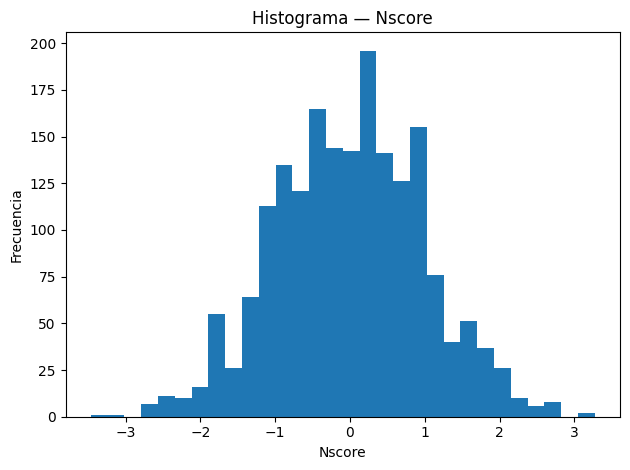

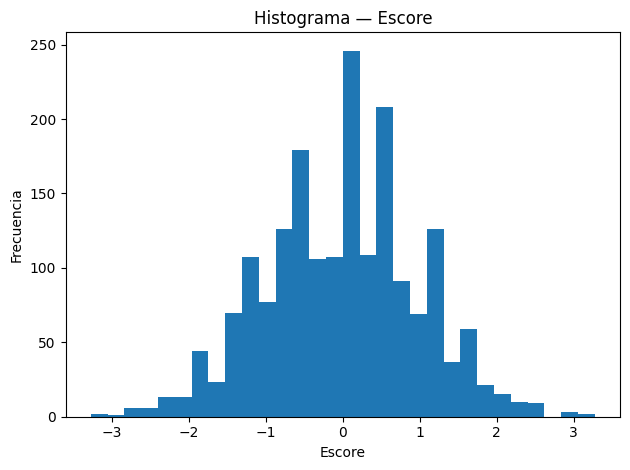

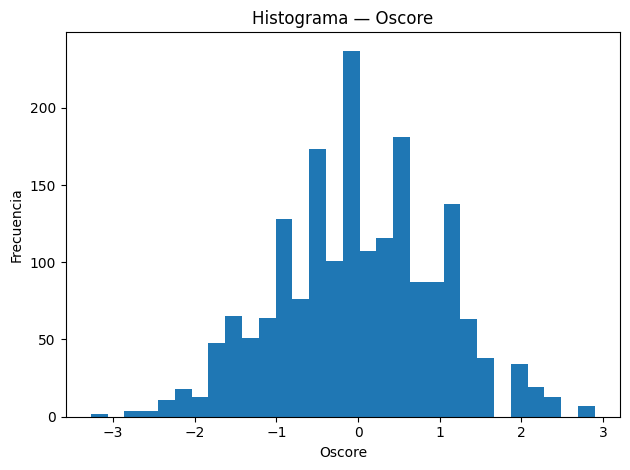

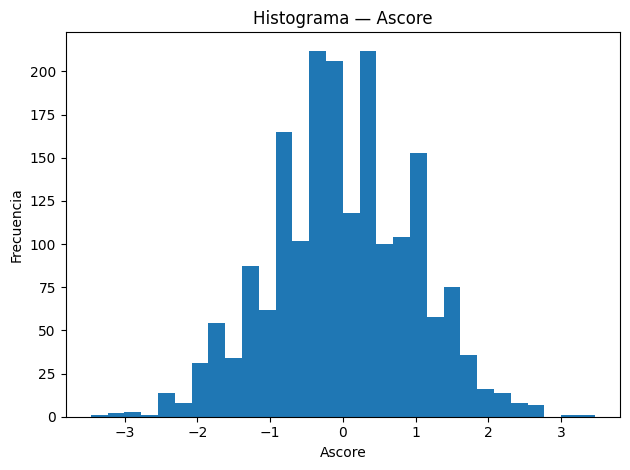

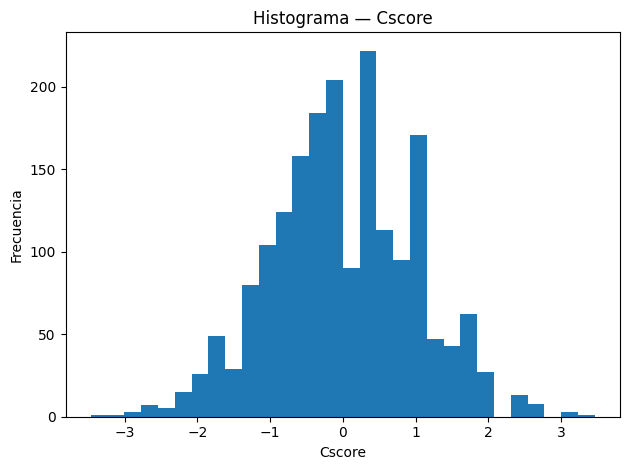

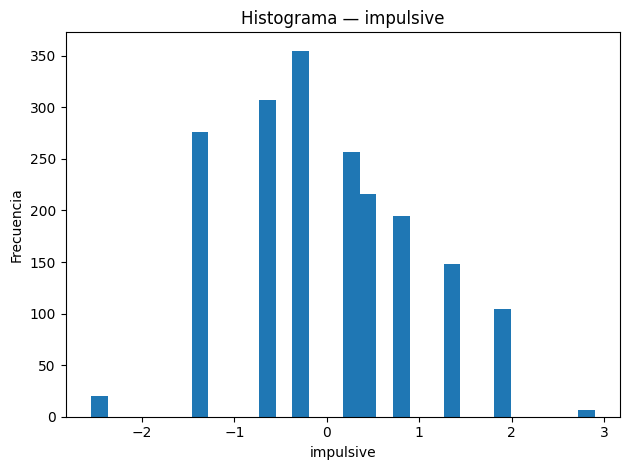

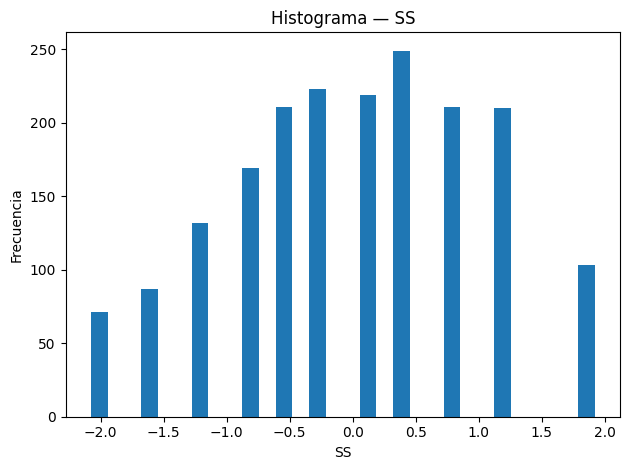

Histogramas guardados en: /app/eda_outputs


In [514]:
# Histogramas — Rasgos psicométricos
for col in psych_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(out_dir / f"hist_{col}.png", dpi=150)
    plt.show()

print("Histogramas guardados en:", out_dir.resolve())


## Conteos y porcentajes por nivel CL (CL0..CL6) para cada droga + CSVs

In [515]:
# CL por droga — Conteos y Porcentajes
cl_counts = {}
cl_perc = {}

for drug in DRUG_COLS:
    counts = df[drug].value_counts(dropna=False).reindex(CL_ORDER, fill_value=0)
    cl_counts[drug] = counts
    cl_perc[drug] = (counts / counts.sum()) * 100.0

cl_counts_df = pd.DataFrame(cl_counts).T[CL_ORDER].astype(int)
cl_perc_df   = pd.DataFrame(cl_perc).T[CL_ORDER]

display(cl_counts_df)
display(cl_perc_df.round(2))

cl_counts_df.to_csv(out_dir / "cl_counts_by_drug.csv")
cl_perc_df.to_csv(out_dir / "cl_percent_by_drug.csv")
print("Guardado:", (out_dir / "cl_counts_by_drug.csv").resolve())
print("Guardado:", (out_dir / "cl_percent_by_drug.csv").resolve())


,CL0,CL1,CL2,CL3,CL4,CL5,CL6
alcohol,34,34,68,198,287,759,505
amphet,976,230,243,198,75,61,102
amyl,1305,210,237,92,24,14,3
benzos,1000,116,234,236,120,84,95
caff,27,10,24,60,106,273,1385
cannabis,413,207,266,211,140,185,463
choc,32,3,10,54,296,683,807
coke,1038,160,270,258,99,41,19
crack,1627,67,112,59,9,9,2
ecstasy,1021,113,234,277,156,63,21


,CL0,CL1,CL2,CL3,CL4,CL5,CL6
alcohol,1.80,1.80,3.61,10.50,15.23,40.27,26.79
amphet,51.78,12.20,12.89,10.50,3.98,3.24,5.41
amyl,69.23,11.14,12.57,4.88,1.27,0.74,0.16
benzos,53.05,6.15,12.41,12.52,6.37,4.46,5.04
caff,1.43,0.53,1.27,3.18,5.62,14.48,73.47
cannabis,21.91,10.98,14.11,11.19,7.43,9.81,24.56
choc,1.70,0.16,0.53,2.86,15.70,36.23,42.81
coke,55.07,8.49,14.32,13.69,5.25,2.18,1.01
crack,86.31,3.55,5.94,3.13,0.48,0.48,0.11
ecstasy,54.16,5.99,12.41,14.69,8.28,3.34,1.11


Guardado: /app/eda_outputs/cl_counts_by_drug.csv
Guardado: /app/eda_outputs/cl_percent_by_drug.csv



## Heatmap de porcentajes CL por droga (guarda PNG)

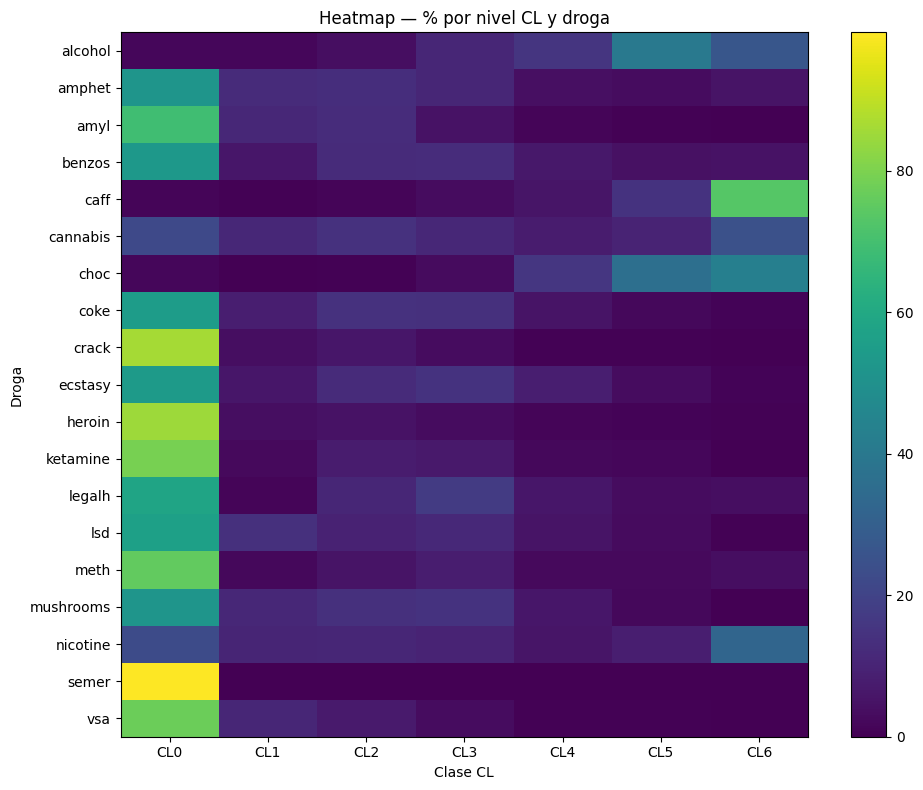

In [516]:
# Heatmap — % por nivel CL y droga (matplotlib imshow)
mat = cl_perc_df.values

plt.figure(figsize=(10, 8))
plt.imshow(mat, aspect="auto")
plt.title("Heatmap — % por nivel CL y droga")
plt.xlabel("Clase CL")
plt.ylabel("Droga")
plt.xticks(ticks=range(len(CL_ORDER)), labels=CL_ORDER, rotation=0)
plt.yticks(ticks=range(len(DRUG_COLS)), labels=DRUG_COLS)
plt.colorbar()
plt.tight_layout()
plt.savefig(out_dir / "heatmap_cl_percent.png", dpi=150)
plt.show()


## Barras por droga (muchas figuras; deja comentado si no las necesitas)

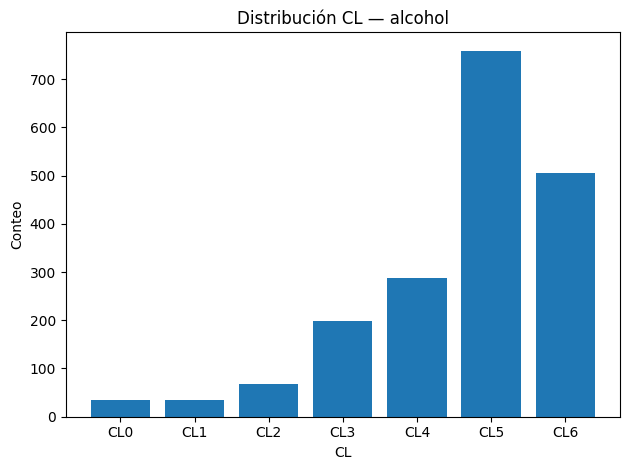

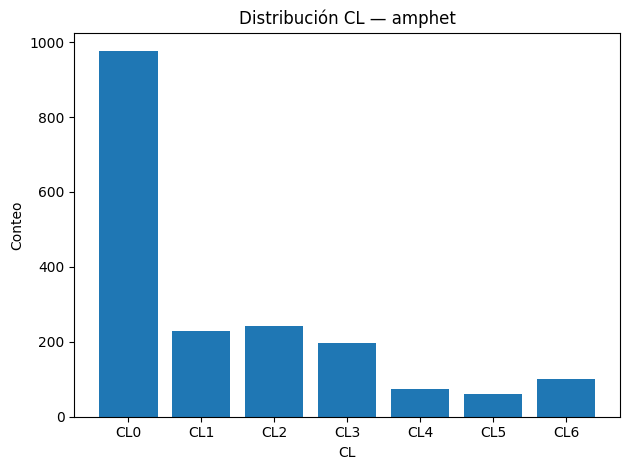

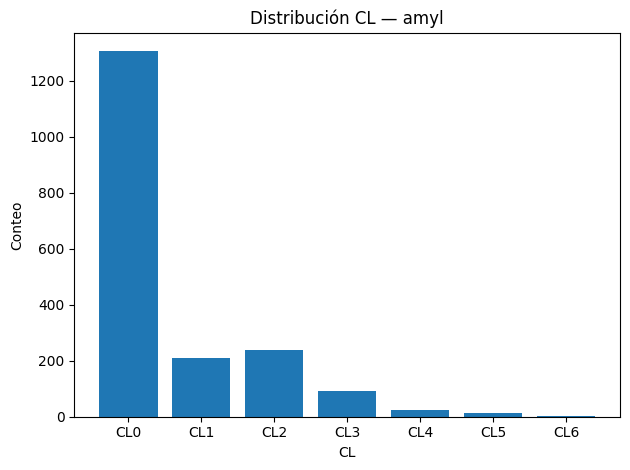

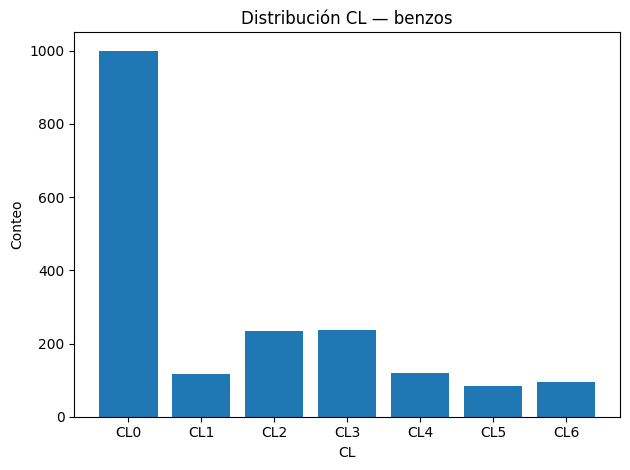

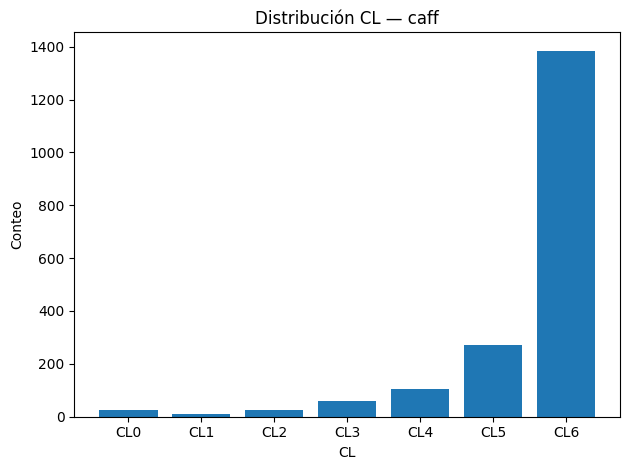

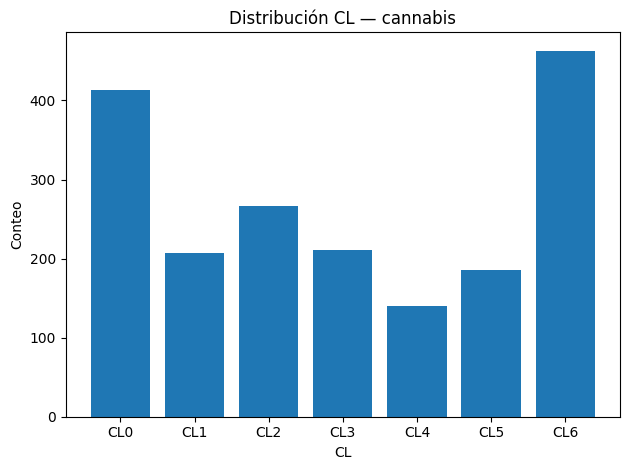

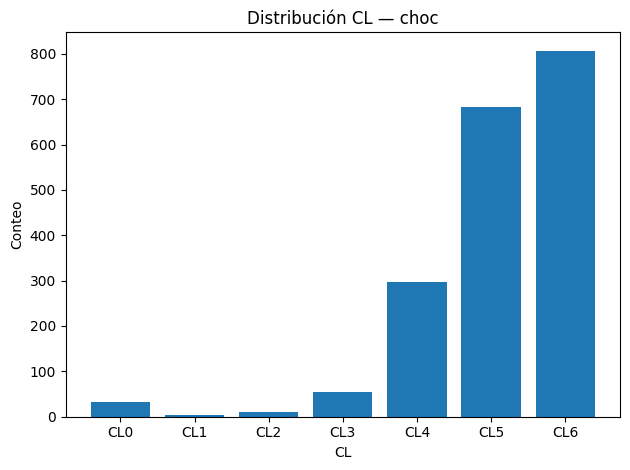

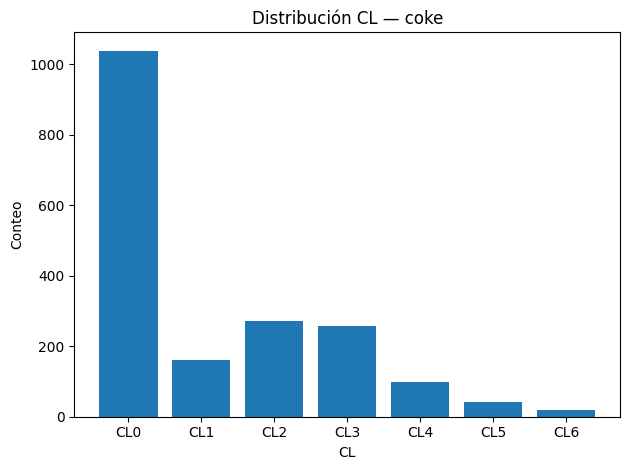

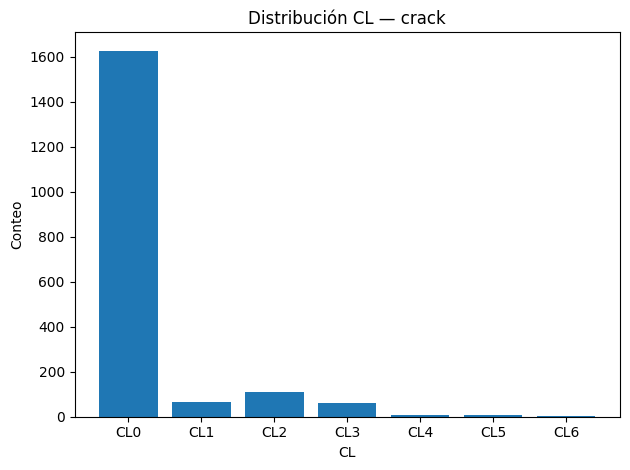

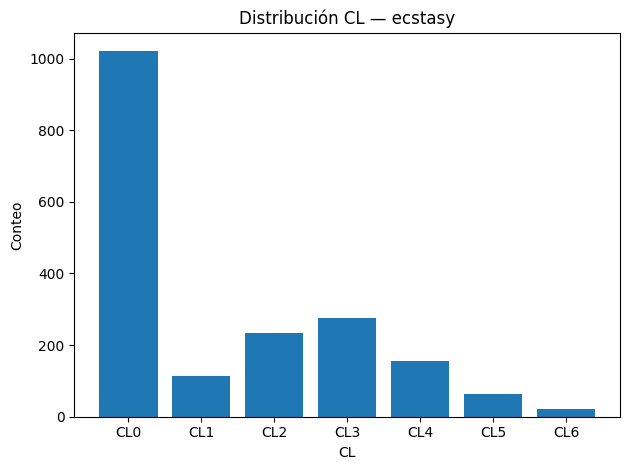

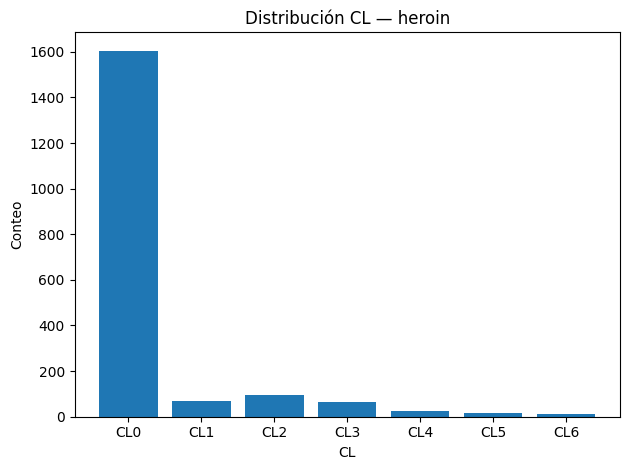

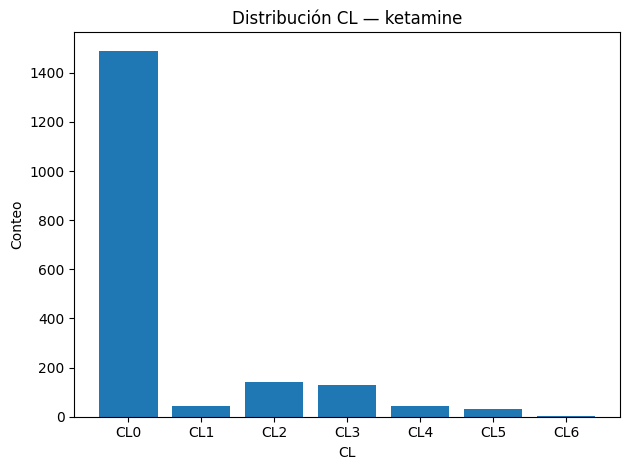

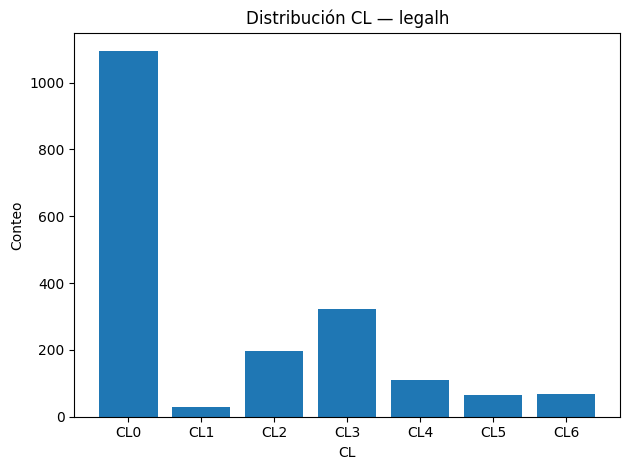

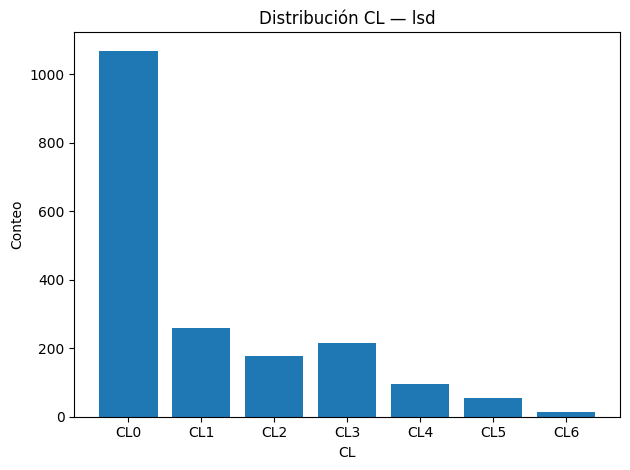

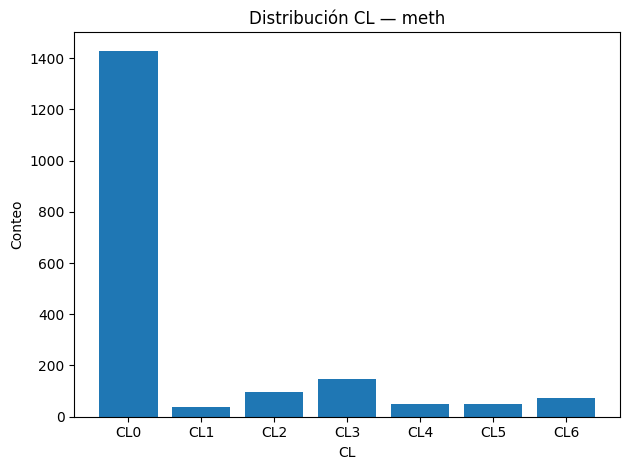

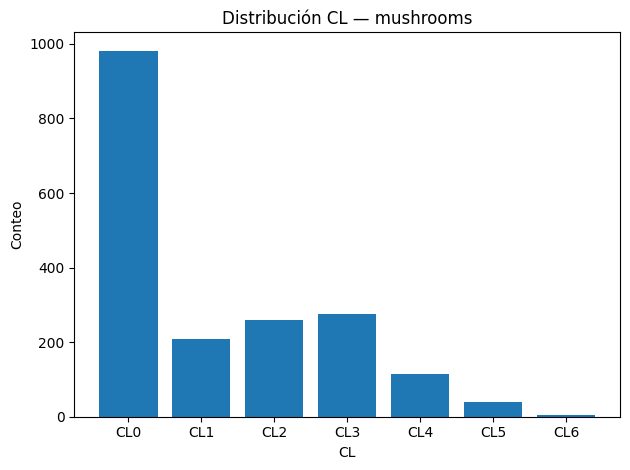

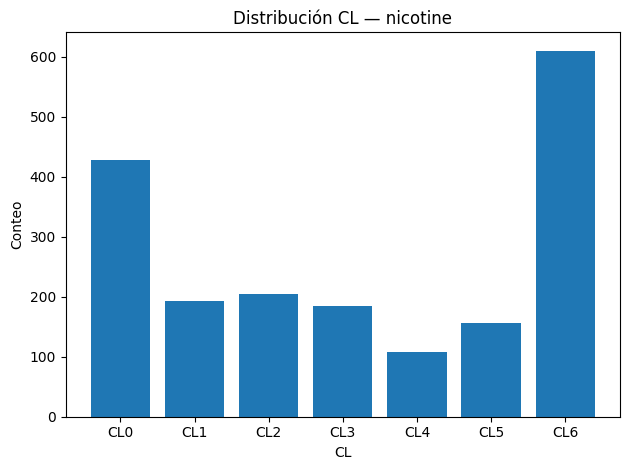

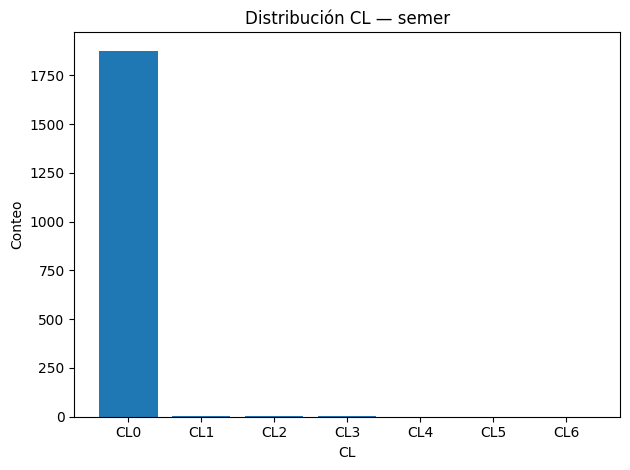

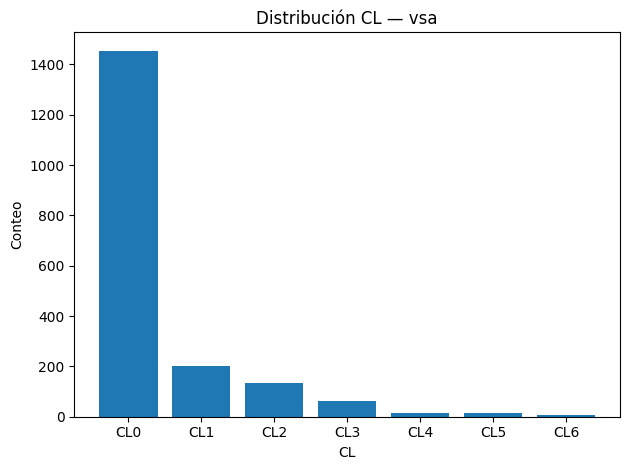

In [517]:
for drug in DRUG_COLS:
    plt.figure()
    series = cl_counts_df.loc[drug]
    plt.bar(series.index.tolist(), series.values.tolist())
    plt.title(f"Distribución CL — {drug}")
    plt.xlabel("CL")
    plt.ylabel("Conteo")
    plt.tight_layout()
    plt.savefig(out_dir / f"bars_{drug}.png", dpi=150)
    plt.show()


## Configuración y conjuntos de valores válidos

estas columnas “reales” (age, gender, education, country, ethnicity) usan códigos numéricos discretos. Validamos contra sus listas oficiales y corregimos redondeos.

In [518]:
import json

# Columnas por tipo (si no las definiste antes)
DRUG_COLS = ["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke",
             "crack","ecstasy","heroin","ketamine","legalh","lsd","meth",
             "mushrooms","nicotine","semer","vsa"]

CL_ORDER = ["CL0","CL1","CL2","CL3","CL4","CL5","CL6"]
psych_cols = ["Nscore","Escore","Oscore","Ascore","Cscore","impulsive","SS"]
coded_cols = ["age","gender","education","country","ethnicity"]

# Conjuntos válidos (de la documentación)
AGE_ALLOWED = [-0.95197, -0.07854, 0.49788, 1.09449, 1.82213, 2.59171]
GENDER_ALLOWED = [-0.48246, 0.48246]
EDU_ALLOWED = [-2.43591,-1.73790,-1.43719,-1.22751,-0.61113,-0.05921,0.45468,1.16365,1.98437]
COUNTRY_ALLOWED = [-0.57009,-0.46841,-0.28519,-0.09765,0.21128,0.24923,0.96082]
ETHNICITY_ALLOWED = [-1.10702,-0.50212,-0.31685,-0.22166,0.11440,0.12600,1.90725]

ALLOWED_MAP = {
    "age": AGE_ALLOWED,
    "gender": GENDER_ALLOWED,
    "education": EDU_ALLOWED,
    "country": COUNTRY_ALLOWED,
    "ethnicity": ETHNICITY_ALLOWED,
}

# Helpers de validación con tolerancia (para corregir redondeos)
def isin_tolerant(s, allowed, tol=1e-5):
    allowed = np.array(allowed, dtype=float)
    def ok(x):
        dif = np.abs(allowed - float(x))
        return np.any(dif <= tol)
    return s.astype(float).map(ok)

def snap_to_allowed(s, allowed, tol=1e-5):
    allowed = np.array(allowed, dtype=float)
    def snap(x):
        dif = np.abs(allowed - float(x))
        i = dif.argmin()
        return allowed[i] if dif[i] <= tol else x
    return s.astype(float).map(snap)

validation_report = {}


## Tipado base y normalización de columnas CL
garantizamos que las CL* estén en mayúsculas/ordenadas y que los rasgos sean numéricos.

In [519]:
# 1) Normaliza CL* (espacios, mayúsculas) y tipa como categóricas ordenadas
for c in DRUG_COLS:
    df[c] = df[c].astype(str).str.strip().str.upper()
    df[c] = pd.Categorical(df[c], categories=CL_ORDER, ordered=True)

# 2) Asegura que los rasgos psicométricos sean numéricos
df[psych_cols] = df[psych_cols].apply(pd.to_numeric, errors="raise")


## Validación/“snap” de códigos reales (age, gender, education, country, ethnicity)

si algún valor cae muy cerca de los válidos por temas de coma flotante, lo “ajustamos” (snap). Si es realmente inválido, lo reportamos.

In [520]:
for col, allowed in ALLOWED_MAP.items():
    ok_mask = isin_tolerant(df[col], allowed, tol=1e-5)
    n_bad = int((~ok_mask).sum())
    validation_report[col] = {"invalid_count_before_snap": n_bad}

    # Corrige vía "snap" los que están dentro de tolerancia
    df.loc[ok_mask, col] = snap_to_allowed(df.loc[ok_mask, col], allowed, tol=1e-5)

# Recuenta luego del snap (por si queda algo realmente inválido)
for col, allowed in ALLOWED_MAP.items():
    still_bad = ~df[col].astype(float).isin(allowed)
    validation_report[col]["invalid_count_after_snap"] = int(still_bad.sum())
    if still_bad.any():
        display(df.loc[still_bad, [col]].head(5))


## Validación de CL* (valores fuera de CL0..CL6) y decisión

si hay valores no reconocidos (typos), mejor eliminarlos: no son interpretables.

In [521]:
# Detecta valores inválidos en CL*
invalid_rows_mask = np.zeros(len(df), dtype=bool)

for c in DRUG_COLS:
    bad_mask = ~df[c].isin(CL_ORDER)
    cnt = int(bad_mask.sum())
    validation_report[c] = {"invalid_count": cnt}
    invalid_rows_mask |= bad_mask

print("Filas con algún CL inválido:", int(invalid_rows_mask.sum()))

# Decisión: eliminar filas con CL inválidos (suelen ser muy pocas y son errores de entrada)
df_clean = df.loc[~invalid_rows_mask].copy()
print("Shape antes:", df.shape, " | después:", df_clean.shape)


Filas con algún CL inválido: 0
Shape antes: (1885, 32)  | después: (1885, 32)


## Chequeos finales de integridad

verificar que todo quedó consistente con la documentación.

In [522]:
# 1) Conteos de categorías codificadas
def counts_series(s):
    vc = s.value_counts(dropna=False)
    try:
        vc = vc.sort_index()
    except Exception:
        pass
    return vc

print("=== Distribuciones codificadas ===")
for col in coded_cols:
    print(f"\n[{col}]")
    print(counts_series(df_clean[col]))

# 2) Conteos por CL
print("\n=== Distribuciones por droga (CL0..CL6) ===")
for drug in DRUG_COLS:
    print(f"\n[{drug}]")
    print(df_clean[drug].value_counts(dropna=False).reindex(CL_ORDER, fill_value=0))


=== Distribuciones codificadas ===

[age]
age
-0.95197    643
-0.07854    481
 0.49788    356
 1.09449    294
 1.82213     93
 2.59171     18
Name: count, dtype: int64

[gender]
gender
-0.48246    943
 0.48246    942
Name: count, dtype: int64

[education]
education
-2.43591     28
-1.73790     99
-1.43719     30
-1.22751    100
-0.61113    506
-0.05921    270
 0.45468    480
 1.16365    283
 1.98437     89
Name: count, dtype: int64

[country]
country
-0.57009     557
-0.46841       5
-0.28519     118
-0.09765      54
 0.21128      20
 0.24923      87
 0.96082    1044
Name: count, dtype: int64

[ethnicity]
ethnicity
-1.10702      33
-0.50212      26
-0.31685    1720
-0.22166      20
 0.11440      63
 0.12600      20
 1.90725       3
Name: count, dtype: int64

=== Distribuciones por droga (CL0..CL6) ===

[alcohol]
alcohol
CL0     34
CL1     34
CL2     68
CL3    198
CL4    287
CL5    759
CL6    505
Name: count, dtype: int64

[amphet]
amphet
CL0    976
CL1    230
CL2    243
CL3    198
CL4 

## Guardado de salidas limpias

dejar una versión “congelada” tras limpieza y un reporte para adjuntar en el informe.

In [523]:
out_dir = Path("./clean_outputs"); out_dir.mkdir(exist_ok=True, parents=True)

clean_csv = out_dir / "drug_consumption_clean.csv"
report_json = out_dir / "validation_report.json"

df_clean.to_csv(clean_csv, index=False)
with report_json.open("w", encoding="utf-8") as f:
    json.dump(validation_report, f, indent=2)

print("Guardado CSV limpio:", clean_csv.resolve())
print("Guardado reporte:", report_json.resolve())


Guardado CSV limpio: /app/clean_outputs/drug_consumption_clean.csv
Guardado reporte: /app/clean_outputs/validation_report.json


## Separar features para clustering

preparar desde ya el set X sin id ni CL*, para usarlo en la fase de preprocesamiento (escalado).

In [524]:
# Solo variables de entrada (sociodemográficas + psicométricas)
X_cols = coded_cols + psych_cols   # excluye 'id' y todas las CL*
X = df_clean[X_cols].copy()

X_csv = out_dir / "X_features_only.csv"
X.to_csv(X_csv, index=False)
print("Guardado X (features):", X_csv.resolve())


Guardado X (features): /app/clean_outputs/X_features_only.csv


## Definir esquema de binarización y drogas a considerar

- Qué hace: define las columnas de features para X y todas las drogas para binarizar.
- Por qué: fijar un contrato reproducible: qué entra al modelo y cómo interpretamos CL0..CL6.

In [525]:
# --- FEATURES PARA CLUSTERING (solo psico + socio) ---
coded_cols = ["age","gender","education","country","ethnicity"]
psych_cols = ["Nscore","Escore","Oscore","Ascore","Cscore","impulsive","SS"]
X_cols = coded_cols + psych_cols  # <- SIN 'id' y SIN columnas de drogas

# --- TODAS LAS DROGAS (incluye chocolate, caffeine, nicotine y Semeron) ---
DRUG_COLS_ALL = [
    "alcohol","amphet","amyl","benzos","cannabis","choc","caff","coke",
    "crack","ecstasy","heroin","ketamine","legalh","lsd","meth","mushrooms",
    "nicotine","vsa","semer"  # incluye VSA y Semeron
]

CL_ORDER = ["CL0","CL1","CL2","CL3","CL4","CL5","CL6"]

def cl_to_binary(cl_value: str) -> int:
    """
    Binariza niveles CL:
      - 0 si CL0 (nunca)
      - 1 si CL1..CL6 (consumidor)
    """
    v = str(cl_value).strip().upper()
    return 0 if v == "CL0" else 1


## Construir X (set de entrada para clustering)

- Qué hace: arma X solo con socio + psico, comprobando ausencia de NaN.
- Por qué: evitar fuga de información (las drogas no deben entrar al algoritmo de clustering).

In [526]:
# Usa df_clean si ya limpiaste; si no, usa df (pero se recomienda df_clean)
try:
    base_df = df_clean.copy()
except NameError:
    base_df = df.copy()

# Construye X únicamente con variables admitidas
X = base_df[X_cols].copy()

# Sanidad: no debería haber NaN tras limpieza; si los hay, imputaste antes
assert not X.isna().any().any(), "X contiene NaN; revisa imputación en la fase de limpieza."

print("X shape:", X.shape)
X.head()


X shape: (1885, 12)


,age,gender,education,country,ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,impulsive,SS
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


## Seleccionar X (solo features para clusterizar)

- Qué hace: arma la matriz de entrada X con sociodemográficas + psicométricas; sin id ni ninguna CL.
- Por qué: evitamos fuga de información (que el modelo “vea” el consumo), y usamos rasgos que tienen sentido para agrupar perfiles.

In [527]:
# Columnas de entrada (features) — las mismas que definimos en la limpieza
coded_cols = ["age","gender","education","country","ethnicity"]
psych_cols = ["Nscore","Escore","Oscore","Ascore","Cscore","impulsive","SS"]
X_cols = coded_cols + psych_cols

# Construye X
X = base_df[X_cols].copy()

# Confirmaciones rápidas
assert not X.isna().any().any(), "Hay NaN en X. Revisa imputación previa."
print("X shape:", X.shape)
X.head()


X shape: (1885, 12)


,age,gender,education,country,ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,impulsive,SS
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


## Estandarizar X (z-score manual)

- Qué hace: lleva cada feature a media 0 y varianza 1.
- Por qué: K-Means/Ward usan distancias euclídeas; sin escalado, variables con mayor escala dominan.

In [528]:
# Z-score manual (sin librerías extra)
mu = X.mean(axis=0)
sigma = X.std(axis=0, ddof=0)           # ddof=0: varianza poblacional
sigma_safe = sigma.replace(0, 1.0)      # evita dividir por 0 si hay columnas constantes

X_scaled = (X - mu) / sigma_safe

print("Medias ~0:\n", X_scaled.mean().round(3))
print("\nDesvíos ~1:\n", X_scaled.std(ddof=0).round(3))


Medias ~0:
 age          0.0
gender       0.0
education    0.0
country      0.0
ethnicity    0.0
Nscore       0.0
Escore      -0.0
Oscore       0.0
Ascore       0.0
Cscore       0.0
impulsive    0.0
SS           0.0
dtype: float64

Desvíos ~1:
 age          1.0
gender       1.0
education    1.0
country      1.0
ethnicity    1.0
Nscore       1.0
Escore       1.0
Oscore       1.0
Ascore       1.0
Cscore       1.0
impulsive    1.0
SS           1.0
dtype: float64


Binarizar consumo 0/1 para cada droga

- Qué hace: crea un DataFrame y_binario con una columna por droga (0/1 según CL).
- Por qué: tu enunciado pide revisar patrones de uso por clúster; esto facilita calcular prevalencias por grupo.

In [529]:
# Normaliza representaciones CL y aplica binarización a TODAS las drogas
y_binario = pd.DataFrame(index=base_df.index)
for drug in DRUG_COLS_ALL:
    col = base_df[drug].astype(str).str.strip().str.upper()
    # Opcional: valida niveles esperados
    bad = ~col.isin(CL_ORDER)
    if bad.any():
        raise ValueError(f"Valores CL no reconocidos en {drug}: {sorted(col[bad].unique().tolist())[:5]}")
    y_binario[drug + "_bin"] = col.map(cl_to_binary).astype(int)

# (Opcional) etiqueta 'any_consumer' = 1 si consumió cualquiera de las 19 drogas
y_binario["any_consumer"] = (y_binario.sum(axis=1) > 0).astype(int)

print(y_binario.head())
print("\nDistribución 'any_consumer':\n", y_binario["any_consumer"].value_counts())


   alcohol_bin  amphet_bin  amyl_bin  benzos_bin  cannabis_bin  choc_bin  \
0            1           1         0           1             0         1   
1            1           1         1           0             1         1   
2            1           0         0           0             1         1   
3            1           0         0           1             1         1   
4            1           1         1           0             1         1   

   caff_bin  coke_bin  crack_bin  ecstasy_bin  heroin_bin  ketamine_bin  \
0         1         0          0            0           0             0   
1         1         1          0            1           0             1   
2         1         0          0            0           0             0   
3         1         1          0            0           0             1   
4         1         0          0            1           0             0   

   legalh_bin  lsd_bin  meth_bin  mushrooms_bin  nicotine_bin  vsa_bin  \
0           0     

## Guardar artefactos

-Qué hace: deja todo persistido para entrenar y analizar.
-Por qué: reproducibilidad y facilidad para los siguientes pasos.

In [530]:
out_dir = Path("./precluster_outputs")
out_dir.mkdir(exist_ok=True, parents=True)

X.to_csv(out_dir / "X_raw.csv", index=False)
X_scaled.to_csv(out_dir / "X_scaled.csv", index=False)
y_binario.to_csv(out_dir / "y_consumo_binario_19_drogas.csv", index=False)

# Guarda parámetros de escalado para aplicarlos igual en futuras corridas
pd.DataFrame({"mu": mu, "sigma": sigma_safe}).to_csv(out_dir / "scaler_params.csv")
print("Guardados en:", out_dir.resolve())


Guardados en: /app/precluster_outputs


## (Sanidad) Resumen rápido de prevalencias 0/1 por droga

- Qué hace: te muestra % de consumidores por droga (global), antes de mirar por clúster.
- Por qué: sirve de baseline para comparar contra las tasas dentro de cada clúster.

In [531]:
n = len(y_binario)
prev = (y_binario.drop(columns=["any_consumer"], errors="ignore").mean(axis=0) * 100).round(2)
prev = prev.sort_values(ascending=False)
print("Prevalencia global (% consumidores) por droga:\n")
print(prev)


Prevalencia global (% consumidores) por droga:

caff_bin         98.57
choc_bin         98.30
alcohol_bin      98.20
cannabis_bin     78.09
nicotine_bin     77.29
amphet_bin       48.22
mushrooms_bin    47.90
benzos_bin       46.95
ecstasy_bin      45.84
coke_bin         44.93
lsd_bin          43.29
legalh_bin       41.96
amyl_bin         30.77
meth_bin         24.19
vsa_bin          22.81
ketamine_bin     20.95
heroin_bin       14.85
crack_bin        13.69
semer_bin         0.42
dtype: float64


## (Sanidad) Resumen rápido de prevalencias 0/1 por droga

- Qué hace: te muestra % de consumidores por droga (global), antes de mirar por clúster.
- Por qué: sirve de baseline para comparar contra las tasas dentro de cada clúster.

In [532]:
n = len(y_binario)
prev = (y_binario.drop(columns=["any_consumer"], errors="ignore").mean(axis=0) * 100).round(2)
prev = prev.sort_values(ascending=False)
print("Prevalencia global (% consumidores) por droga:\n")
print(prev)


Prevalencia global (% consumidores) por droga:

caff_bin         98.57
choc_bin         98.30
alcohol_bin      98.20
cannabis_bin     78.09
nicotine_bin     77.29
amphet_bin       48.22
mushrooms_bin    47.90
benzos_bin       46.95
ecstasy_bin      45.84
coke_bin         44.93
lsd_bin          43.29
legalh_bin       41.96
amyl_bin         30.77
meth_bin         24.19
vsa_bin          22.81
ketamine_bin     20.95
heroin_bin       14.85
crack_bin        13.69
semer_bin         0.42
dtype: float64


## Escalado con StandardScaler

- Qué hace: estandariza cada feature a media 0 y varianza 1.
- Por qué: PCA y los métodos de clustering basados en distancia requieren que todas las variables contribuyan de forma comparable.

In [533]:

# Si ya tienes X (solo psico + socio), úsalo; si no, constrúyelo:
# coded_cols = ["age","gender","education","country","ethnicity"]
# psych_cols = ["Nscore","Escore","Oscore","Ascore","Cscore","impulsive","SS"]
# X = base_df[coded_cols + psych_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # ndarray (n_samples, n_features)

print("Shape X_scaled:", X_scaled.shape)


Shape X_scaled: (1885, 12)


## PCA y varianza explicada

- Qué hace: ajusta PCA en X_scaled, muestra scree plot y acumulada.
- Por qué: para saber si 2–4 PCs capturan una fracción razonable de la varianza (estructura de baja dimensión).

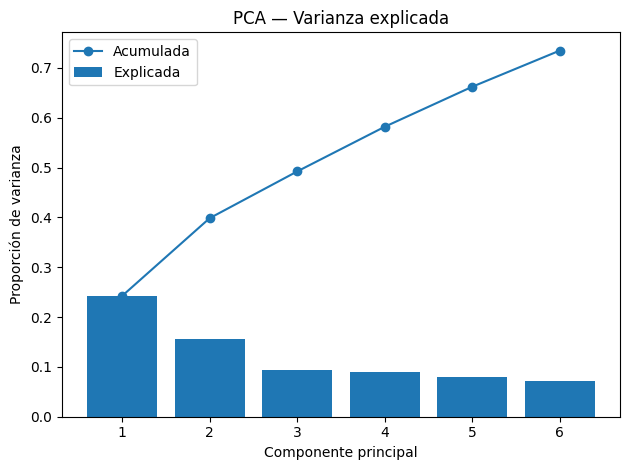

Varianza explicada (%): [24.25 15.6   9.38  8.96  8.03  7.26]
Acumulada (%): [24.25 39.85 49.23 58.19 66.22 73.48]
PCs para ~80%: 8 | para ~90%: 10


In [534]:


# Ajuste PCA (todas las componentes disponibles)
pca = PCA(n_components=None, random_state=0)
pca.fit(X_scaled)

evr = pca.explained_variance_ratio_
evr_cum = np.cumsum(evr)

# Scree + acumulada
k_view = min(6, X_scaled.shape[1])  # mira al menos las primeras 6
plt.figure()
plt.bar(range(1, k_view+1), evr[:k_view], label="Explicada")
plt.plot(range(1, k_view+1), evr_cum[:k_view], marker="o", label="Acumulada")
plt.title("PCA — Varianza explicada")
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza")
plt.legend()
plt.tight_layout()
plt.show()

print("Varianza explicada (%):", np.round(evr[:k_view]*100, 2))
print("Acumulada (%):", np.round(evr_cum[:k_view]*100, 2))

# (Opcional) cuántas PCs para cubrir ~80–90%
k80 = int(np.searchsorted(evr_cum, 0.80) + 1)
k90 = int(np.searchsorted(evr_cum, 0.90) + 1)
print(f"PCs para ~80%: {k80} | para ~90%: {k90}")


## Proyección y scatter PC1-PC2 / PC1-PC3

- Qué hace: proyecta los datos y dibuja mapas 2D.
- Por qué: detectar separaciones potenciales o gradientes (solo exploración).

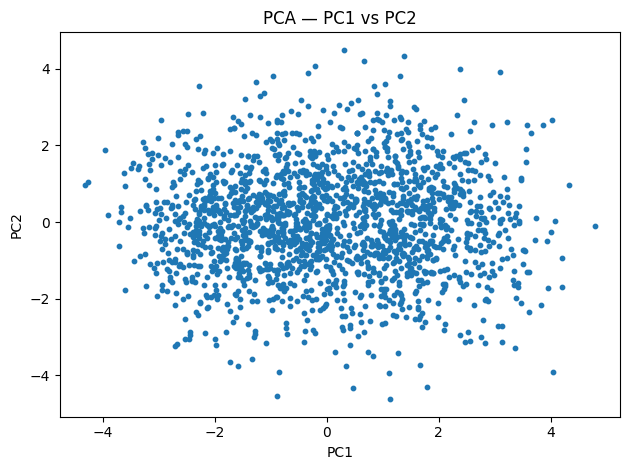

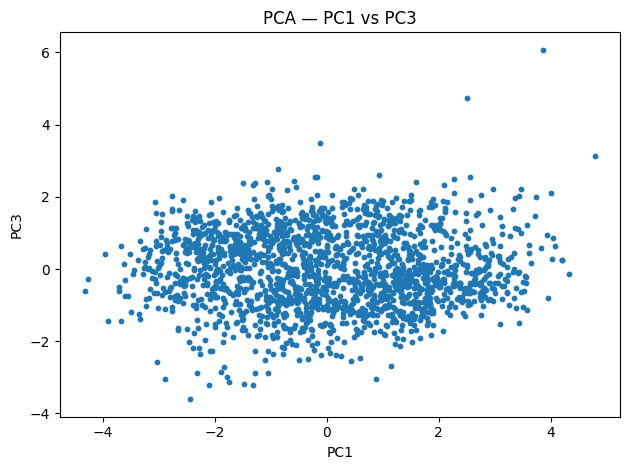

In [535]:
scores = pca.transform(X_scaled)  # (n_samples, n_features)

# PC1 vs PC2
plt.figure()
plt.scatter(scores[:, 0], scores[:, 1], s=10)
plt.title("PCA — PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# PC1 vs PC3 (si existe)
if scores.shape[1] >= 3:
    plt.figure()
    plt.scatter(scores[:, 0], scores[:, 2], s=10)
    plt.title("PCA — PC1 vs PC3")
    plt.xlabel("PC1")
    plt.ylabel("PC3")
    plt.tight_layout()
    plt.show()


## Colorear por any_consumer o una droga binaria

- Qué hace: colorea los puntos por una etiqueta 0/1 solo para entender si la proyección ya sugiere dos grupos parecidos a consumidor/no.
- Por qué: intuición visual; no supervisa el clustering.

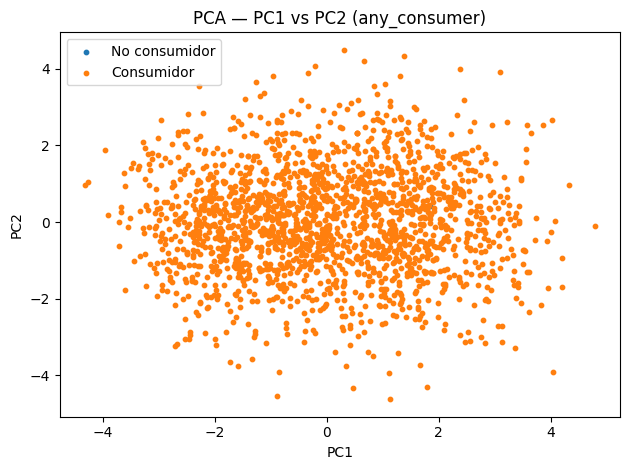

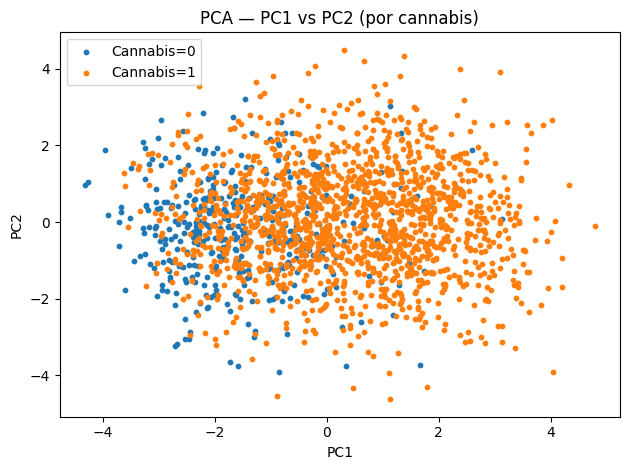

In [536]:
# Requiere y_binario (del paso de binarización 19 drogas)
# y_binario["any_consumer"] = (alguna droga consumida) ∈ {0,1}
try:
    y_plot = y_binario["any_consumer"].to_numpy()
    idx0 = (y_plot == 0)
    idx1 = (y_plot == 1)

    plt.figure()
    plt.scatter(scores[idx0, 0], scores[idx0, 1], s=10, label="No consumidor")
    plt.scatter(scores[idx1, 0], scores[idx1, 1], s=10, label="Consumidor")
    plt.title("PCA — PC1 vs PC2 (any_consumer)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Coloreado por any_consumer omitido:", e)

try:
    y_can = y_binario["cannabis_bin"].to_numpy()
    plt.figure()
    plt.scatter(scores[y_can==0, 0], scores[y_can==0, 1], s=10, label="Cannabis=0")
    plt.scatter(scores[y_can==1, 0], scores[y_can==1, 1], s=10, label="Cannabis=1")
    plt.title("PCA — PC1 vs PC2 (por cannabis)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Coloreado por cannabis omitido:", e)


## Cargas (importancia de cada variable en PC1/PC2)

- Qué hace: muestra cuánto pesa cada feature en las primeras PCs.
- Por qué: interpretar ejes (qué variables “empujan” PC1 y PC2).

In [537]:
# pca.components_: (n_components, n_features)
loadings = pca.components_.T  # (n_features, n_components)
feat_names = list(X.columns)

L = pd.DataFrame(loadings[:, :2], index=feat_names, columns=["PC1_loading","PC2_loading"])

top_n = 8
print("\nTop |carga| en PC1:")
print(L.reindex(L["PC1_loading"].abs().sort_values(ascending=False).index).head(top_n))
print("\nTop |carga| en PC2:")
print(L.reindex(L["PC2_loading"].abs().sort_values(ascending=False).index).head(top_n))



Top |carga| en PC1:
           PC1_loading  PC2_loading
SS            0.434562     0.279364
impulsive     0.403602     0.135811
country      -0.369564    -0.037862
Cscore       -0.339113     0.335201
age          -0.308146    -0.093293
Oscore        0.272054     0.386718
gender       -0.245225    -0.014790
Ascore       -0.243547     0.225430

Top |carga| en PC2:
           PC1_loading  PC2_loading
Escore       -0.052297     0.593353
Nscore        0.218292    -0.440666
Oscore        0.272054     0.386718
Cscore       -0.339113     0.335201
SS            0.434562     0.279364
Ascore       -0.243547     0.225430
education    -0.215109     0.176400
impulsive     0.403602     0.135811


## Guardar artefactos PCA (para el informe)

- Qué hace: persiste varianza, scores y cargas.
- Por qué: reproducibilidad.

In [538]:
out_pca = Path("./pca_outputs"); out_pca.mkdir(exist_ok=True, parents=True)

pd.DataFrame({
    "evr": evr,
    "evr_cum": evr_cum
}).to_csv(out_pca / "explained_variance.csv", index_label="PC")

pd.DataFrame(scores, columns=[f"PC{i+1}" for i in range(scores.shape[1])]).to_csv(out_pca / "scores.csv", index=False)
pd.DataFrame(loadings, index=feat_names, columns=[f"PC{i+1}" for i in range(loadings.shape[1])]).to_csv(out_pca / "loadings.csv")

print("Guardados en:", out_pca.resolve())


Guardados en: /app/pca_outputs


## Utilidades y métricas internas (silhouette, CH, DB)

- Qué: funciones comunes para evaluar un vector de etiquetas.
- Por qué: comparar K-Means vs Ward (y HDBSCAN) con criterios estándar.

In [539]:
def cluster_internal_metrics(Xs, labels):
    """Métricas internas clásicas para clustering con distancia euclídea."""
    # Algunos algoritmos pueden producir clusters vacíos o 1 solo cluster (p.ej., HDBSCAN con mucho ruido)
    unique = np.unique(labels)
    if len(unique) < 2 or (len(unique) == 2 and -1 in unique and (labels != -1).sum() == 0):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    # Silhouette no soporta etiqueta -1 (ruido). Filtra si hace falta.
    mask = labels != -1
    try:
        sil = silhouette_score(Xs[mask], labels[mask]) if (~mask).any() else silhouette_score(Xs, labels)
    except Exception:
        sil = np.nan
    try:
        ch = calinski_harabasz_score(Xs[mask], labels[mask]) if (~mask).any() else calinski_harabasz_score(Xs, labels)
    except Exception:
        ch = np.nan
    try:
        db = davies_bouldin_score(Xs[mask], labels[mask]) if (~mask).any() else davies_bouldin_score(Xs, labels)
    except Exception:
        db = np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db}


## K-Means (euclídea, k-means++, muchos reinicios)

- Qué: entrenamiento estable con n_init=50 y random_state fijo.
- Por qué: K-Means asume clústeres “esféricos”; muchos reinicios reducen sensibilidad a la inicialización.

In [540]:

def fit_kmeans_k2(Xs, n_init=50, random_state=7):
    """
    K-Means con k=2, init='k-means++' y muchos reinicios para estabilidad.
    Xs: matriz estandarizada (solo psico + socio).
    """
    km = KMeans(
        n_clusters=2,
        init="k-means++",
        n_init=n_init,
        random_state=random_state
    )
    labels = km.fit_predict(Xs)
    metrics = cluster_internal_metrics(Xs, labels)
    return km, labels, metrics

# Ejecución
km_model, km_labels, km_metrics = fit_kmeans_k2(X_scaled)
print("K-Means (k=2) métricas:", km_metrics)


K-Means (k=2) métricas: {'silhouette': 0.1662547992189176, 'calinski_harabasz': 391.0417079941296, 'davies_bouldin': 2.0999810436624253}


## Jerárquico aglomerativo (Ward)

- Qué: enlace Ward con métrica euclídea y n_clusters=2.
- Por qué: Ward minimiza la varianza intra-cluster; es comparable a K-Means pero no requiere centroides iniciales. Permite dendrograma (ver siguiente estrofa).

In [541]:

def fit_agg_ward_k2(Xs):
    """
    Clustering jerárquico aglomerativo con enlace Ward (euclídeo) y k=2.
    """
    agg = AgglomerativeClustering(
        n_clusters=2,
        linkage="ward",      # obliga a euclídea
        metric="euclidean"   # explícito por claridad
    )
    labels = agg.fit_predict(Xs)
    metrics = cluster_internal_metrics(Xs, labels)
    return agg, labels, metrics

# Ejecución
agg_model, agg_labels, agg_metrics = fit_agg_ward_k2(X_scaled)
print("Ward (k=2) métricas:", agg_metrics)


Ward (k=2) métricas: {'silhouette': 0.13590008448308863, 'calinski_harabasz': 306.1692712235588, 'davies_bouldin': 2.368243836441464}


## Dendrograma (opcional, diagnóstico de cortes)

- Qué: dendrograma sobre una muestra (para que sea legible).
- Por qué: visualizar niveles de fusión y validar si un corte en 2 grupos es razonable.

In [542]:
# Dendrograma con scipy (usa una muestra para evitar figuras gigantes)

def plot_dendrogram_sample(Xs, sample_size=400, random_state=7):
    rng = np.random.default_rng(random_state)
    idx = rng.choice(Xs.shape[0], size=min(sample_size, Xs.shape[0]), replace=False)
    Z = linkage(Xs[idx], method="ward", metric="euclidean")
    plt.figure(figsize=(10, 4))
    dendrogram(Z, no_labels=True, count_sort=True)
    plt.title("Dendrograma (Ward) — muestra")
    plt.tight_layout()
    plt.show()

# Llamada opcional:
# plot_dendrogram_sample(X_scaled, sample_size=400)


## HDBSCAN (formas irregulares + ruido)

- Qué: clústeres con forma arbitraria; etiqueta ruido como −1.
- Por qué: si los grupos no son esféricos/compactos, HDBSCAN puede captar estructura. Ajusta min_cluster_size/min_samples.

In [543]:
# HDBSCAN es externo a scikit-learn. Instálalo si no lo tienes:
# !pip install hdbscan

def fit_hdbscan(Xs, min_cluster_size=60, min_samples=60, cluster_selection_epsilon=0.0, metric="euclidean"):
    try:
        import hdbscan
    except ImportError:
        print("Instala hdbscan: pip install hdbscan")
        return None, None, {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        metric=metric
    )
    labels = hdb.fit_predict(Xs)
    metrics = cluster_internal_metrics(Xs, labels)
    # Resumen de tamaños (etiqueta -1 = ruido)
    _, counts = np.unique(labels, return_counts=True)
    print("HDBSCAN clusters (incluye -1=ruido) ->", dict(zip(*np.unique(labels, return_counts=True))))
    return hdb, labels, metrics

# Ejecución opcional
# hdb_model, hdb_labels, hdb_metrics = fit_hdbscan(X_scaled, min_cluster_size=60, min_samples=60)
# print("HDBSCAN métricas:", hdb_metrics)


## Acuerdo externo con “consumidor vs no”

- Qué: solo para reporte, no para entrenar. Compara etiquetas de clústeres con any_consumer (0/1).
- Por qué: mostrar si K=2 alinea con la hipótesis “consumidor/no”.

In [544]:

def external_agreement(labels, y_any):
    # Reetiquetar si invierte signos (0↔1) no afecta ARI/NMI, pero igual comparamos tal cual
    return {
        "ARI": adjusted_rand_score(y_any, labels),
        "NMI": normalized_mutual_info_score(y_any, labels)
    }

# Requiere y_binario["any_consumer"]
y_any = y_binario["any_consumer"].to_numpy()

print("K-Means acuerdo externo:", external_agreement(km_labels, y_any))
print("Ward   acuerdo externo:", external_agreement(agg_labels, y_any))
# if hdb_labels is not None:
#     print("HDBSCAN acuerdo externo (sin ruido):", external_agreement(hdb_labels[hdb_labels!=-1], y_any[hdb_labels!=-1]))


K-Means acuerdo externo: {'ARI': 0.00019279626034935082, 'NMI': 0.0011927816510024457}
Ward   acuerdo externo: {'ARI': -9.155876974312271e-05, 'NMI': 0.0009888525811506171}


## Persistir etiquetas para análisis posterior

- Qué: guarda labels para construir tablas de prevalencia por clúster.
- Por qué: lo pide la rúbrica (análisis de grupos y relación con consumo).

In [545]:
from pathlib import Path
import pandas as pd

out_dir = Path("./cluster_outputs"); out_dir.mkdir(exist_ok=True, parents=True)

pd.Series(km_labels, name="kmeans_k2").to_csv(out_dir / "labels_kmeans_k2.csv", index=False)
pd.Series(agg_labels, name="ward_k2").to_csv(out_dir / "labels_ward_k2.csv", index=False)
print("Etiquetas guardadas en:", out_dir.resolve())


Etiquetas guardadas en: /app/cluster_outputs


## Utilidades (métricas internas + inercia por etiquetas)

- Qué hace: funciones compartidas para evaluar cualquier partición.
- Por qué: necesitamos comparar métodos y diferentes K con criterios consistentes.

In [546]:

def cluster_internal_metrics(Xs, labels):
    """
    Devuelve métricas internas para una asignación de clusters:
      - silhouette (↑ mejor)
      - calinski_harabasz (↑ mejor)
      - davies_bouldin (↓ mejor)
    Nota: ignora etiqueta -1 (si existiera) para silhouette/CH/DB.
    """
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    if len(uniq) < 2 or (len(uniq) == 2 and -1 in uniq and (labels != -1).sum() == 0):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}
    mask = labels != -1
    Xm = Xs[mask]
    ym = labels[mask]
    try:
        sil = silhouette_score(Xm, ym)
    except Exception:
        sil = np.nan
    try:
        ch = calinski_harabasz_score(Xm, ym)
    except Exception:
        ch = np.nan
    try:
        db = davies_bouldin_score(Xm, ym)
    except Exception:
        db = np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db}

def inertia_from_labels(Xs, labels):
    """
    'Inercia' general: suma de distancias cuadráticas a los centroides de cada cluster.
    Útil para 'elbow' incluso cuando el modelo no expone .inertia_ (p.ej., Ward).
    """
    Xs = np.asarray(Xs, dtype=float)
    labels = np.asarray(labels)
    inertia = 0.0
    for c in np.unique(labels):
        if c == -1:  # por si aplicas a métodos con ruido
            continue
        idx = labels == c
        if idx.sum() == 0:
            continue
        center = Xs[idx].mean(axis=0, dtype=float)
        dif = Xs[idx] - center
        inertia += float((dif * dif).sum())
    return inertia


# K-Means: barrido K=2…10, métricas y elbow

- Qué hace: ejecuta K-Means para cada K, calcula métricas e inercia y grafica curvas.
- Por qué: K-Means asume compacidad/esfericidad; n_init alto da estabilidad.

,inertia,silhouette,calinski_harabasz,davies_bouldin
K,,,,
2,18730.290,0.166,391.042,2.100
3,17301.693,0.134,289.252,2.193
4,16352.893,0.114,240.292,2.383
5,15609.647,0.105,211.081,2.282
6,14950.107,0.110,192.798,2.045
7,14413.654,0.108,178.205,2.107
8,13888.238,0.109,168.586,1.885
9,13401.228,0.108,161.314,1.815
10,13077.204,0.102,152.027,1.835


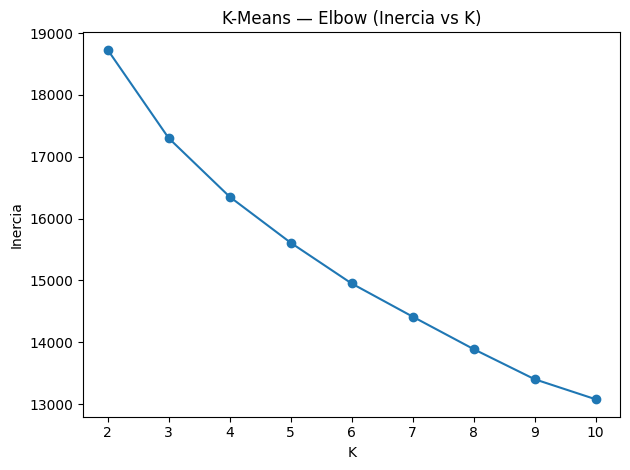

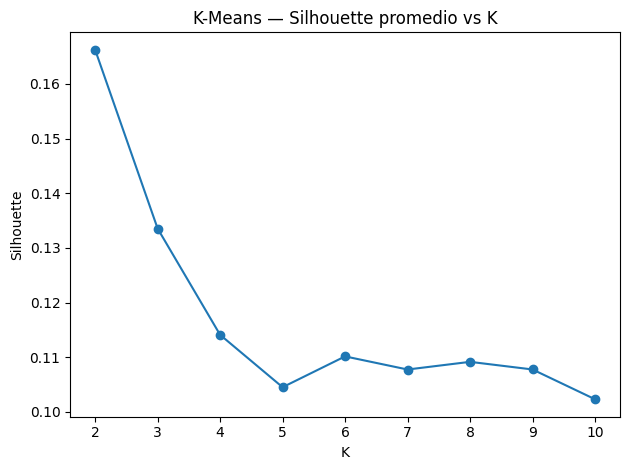

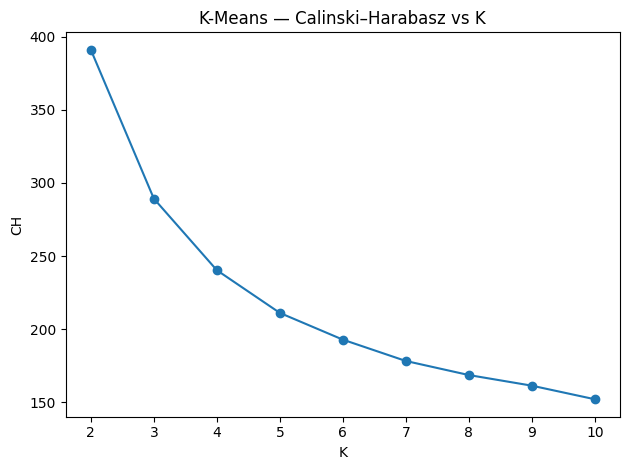

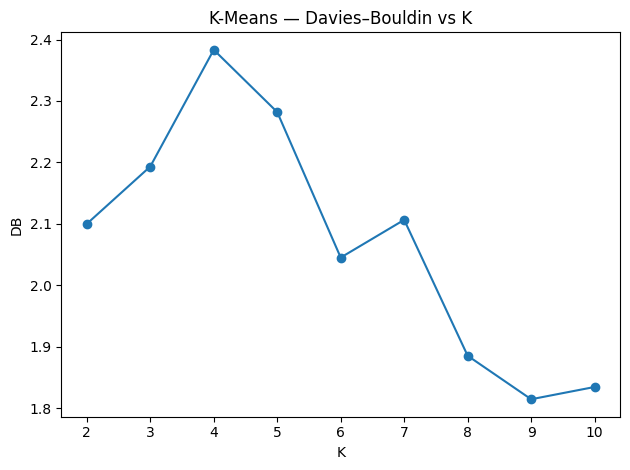

In [547]:

K_RANGE = list(range(2, 11))  # 2..10

km_results = []
for k in K_RANGE:
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=50,
        random_state=7
    )
    labels = km.fit_predict(X_scaled)
    m = cluster_internal_metrics(X_scaled, labels)
    km_results.append({
        "K": k,
        "inertia": float(km.inertia_),  # propio de KMeans
        "silhouette": m["silhouette"],
        "calinski_harabasz": m["calinski_harabasz"],
        "davies_bouldin": m["davies_bouldin"],
    })

km_df = pd.DataFrame(km_results).set_index("K")
display(km_df.round(3))

# Gráficas (una por figura, sin seaborn)
plt.figure()
plt.plot(km_df.index, km_df["inertia"], marker="o")
plt.title("K-Means — Elbow (Inercia vs K)")
plt.xlabel("K")
plt.ylabel("Inercia")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(km_df.index, km_df["silhouette"], marker="o")
plt.title("K-Means — Silhouette promedio vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(km_df.index, km_df["calinski_harabasz"], marker="o")
plt.title("K-Means — Calinski–Harabasz vs K")
plt.xlabel("K")
plt.ylabel("CH")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(km_df.index, km_df["davies_bouldin"], marker="o")
plt.title("K-Means — Davies–Bouldin vs K")
plt.xlabel("K")
plt.ylabel("DB")
plt.tight_layout()
plt.show()


## Jerárquico (Ward): corta a varios K y evalúa

- Qué hace: computa la jerarquía una vez y corta a K=2…10; evalúa mismas métricas e “inercia general”.
- Por qué: Ward busca compacidad (similar a K-Means), pero no depende de inicialización; el corte en K es interpretable vía dendrograma.

,inertia,silhouette,calinski_harabasz,davies_bouldin
K,,,,
2,19456.449,0.136,306.169,2.368
3,18626.790,0.095,201.732,2.684
4,17829.717,0.048,168.455,2.869
5,17111.445,0.057,151.303,2.482
6,16423.124,0.068,141.799,2.379
7,15853.671,0.063,133.588,2.287
8,15366.406,0.060,126.575,2.416
9,14946.613,0.063,120.389,2.362
10,14566.545,0.065,115.182,2.291


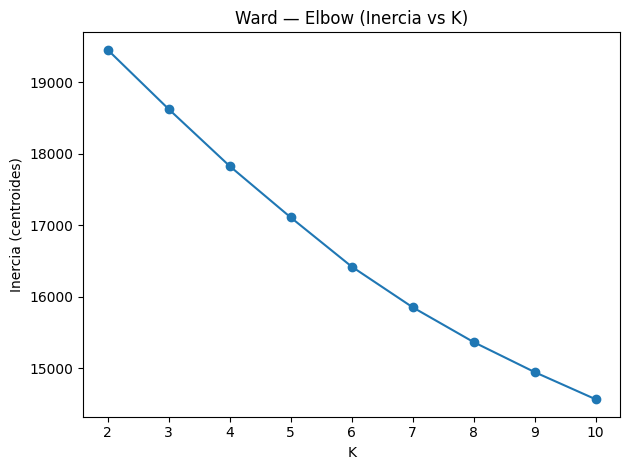

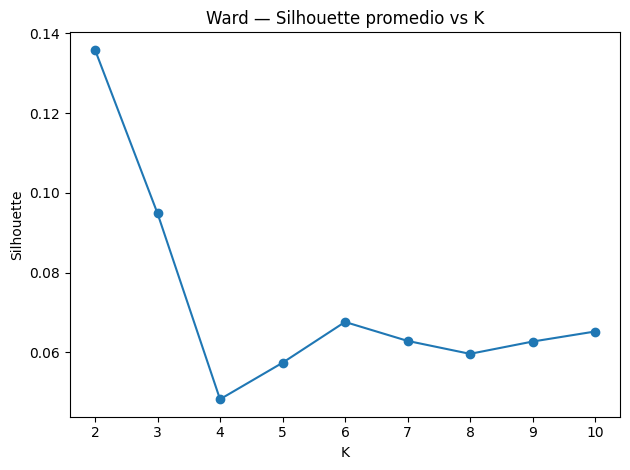

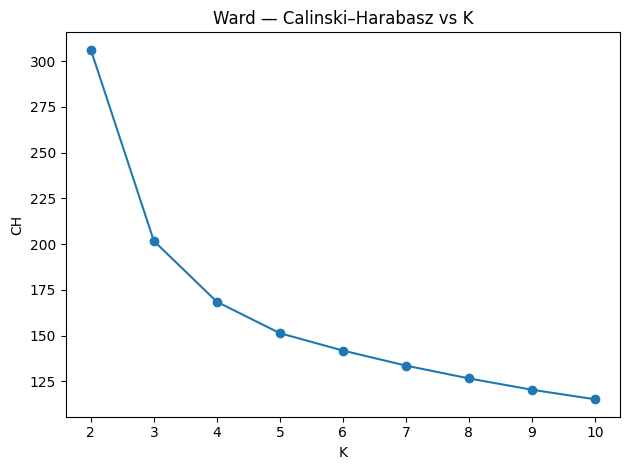

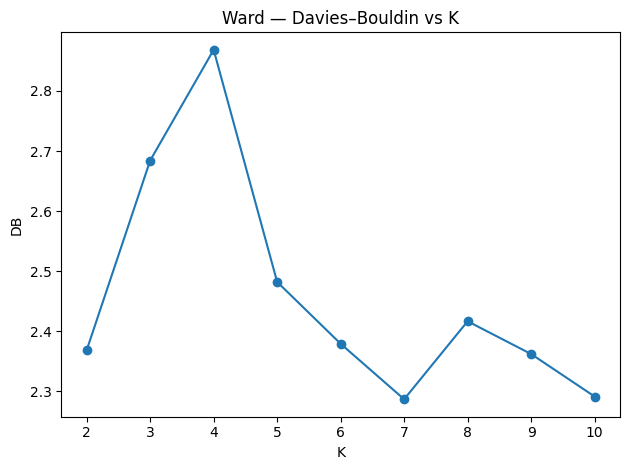

In [548]:

# OJO: linkage con Ward en todo el dataset puede ser costoso en memoria si n es muy grande.
Z = linkage(X_scaled, method="ward", metric="euclidean")

ward_results = []
for k in K_RANGE:
    labels = fcluster(Z, t=k, criterion="maxclust")  # etiquetas 1..k
    # Reindex a 0..k-1 para consistencia
    _, labels0 = np.unique(labels, return_inverse=True)
    m = cluster_internal_metrics(X_scaled, labels0)
    inertia_val = inertia_from_labels(X_scaled, labels0)
    ward_results.append({
        "K": k,
        "inertia": inertia_val,
        "silhouette": m["silhouette"],
        "calinski_harabasz": m["calinski_harabasz"],
        "davies_bouldin": m["davies_bouldin"],
    })

ward_df = pd.DataFrame(ward_results).set_index("K")
display(ward_df.round(3))

# Curvas
plt.figure()
plt.plot(ward_df.index, ward_df["inertia"], marker="o")
plt.title("Ward — Elbow (Inercia vs K)")
plt.xlabel("K")
plt.ylabel("Inercia (centroides)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(ward_df.index, ward_df["silhouette"], marker="o")
plt.title("Ward — Silhouette promedio vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(ward_df.index, ward_df["calinski_harabasz"], marker="o")
plt.title("Ward — Calinski–Harabasz vs K")
plt.xlabel("K")
plt.ylabel("CH")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(ward_df.index, ward_df["davies_bouldin"], marker="o")
plt.title("Ward — Davies–Bouldin vs K")
plt.xlabel("K")
plt.ylabel("DB")
plt.tight_layout()
plt.show()


## Distribución de silhouette por K (promedio + forma)

- Qué hace: además del promedio, mira la dispersión de los coeficientes de silhouette para algunos K candidatos.
- Por qué: valores medios de ~0.25–0.5 pueden ser útiles en datos sociales; ver la forma ayuda a detectar solape

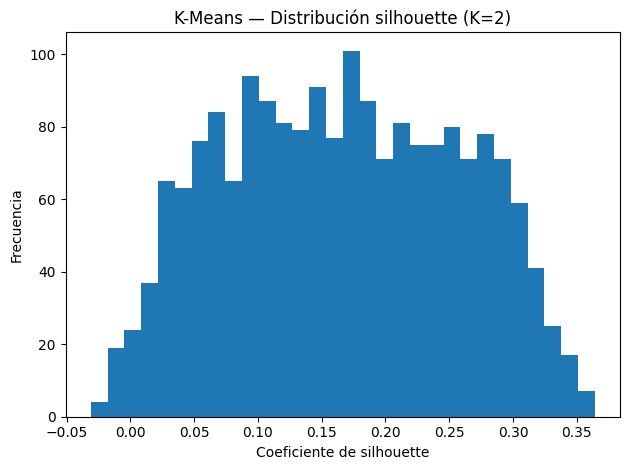

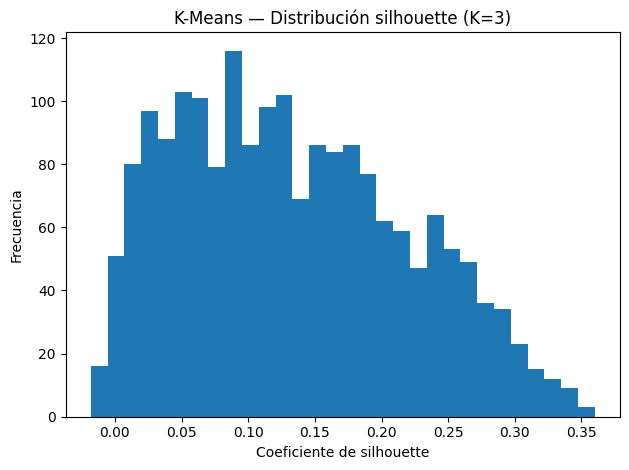

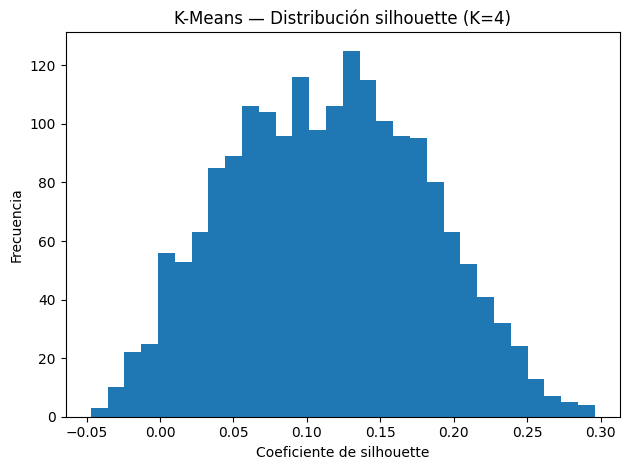

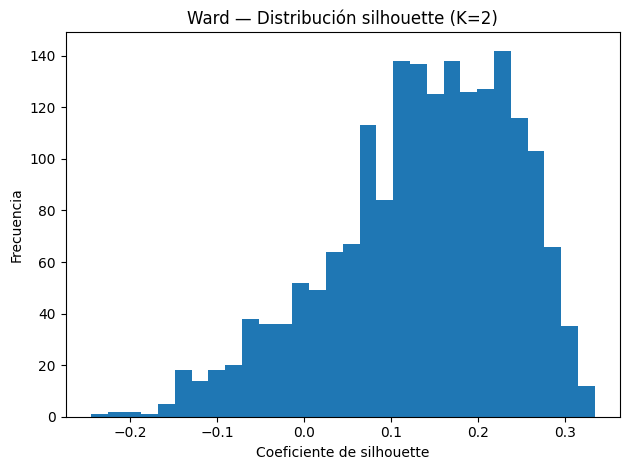

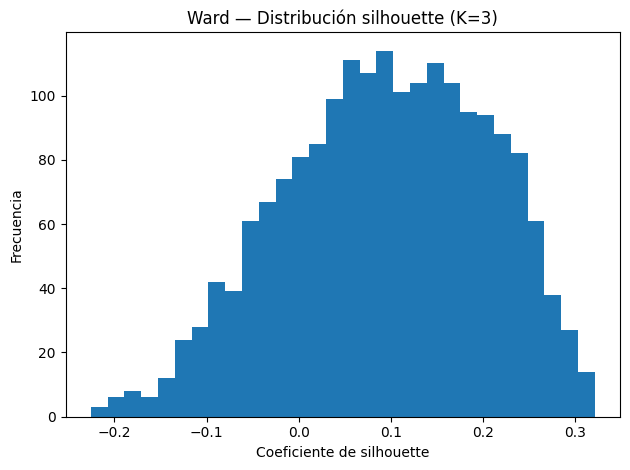

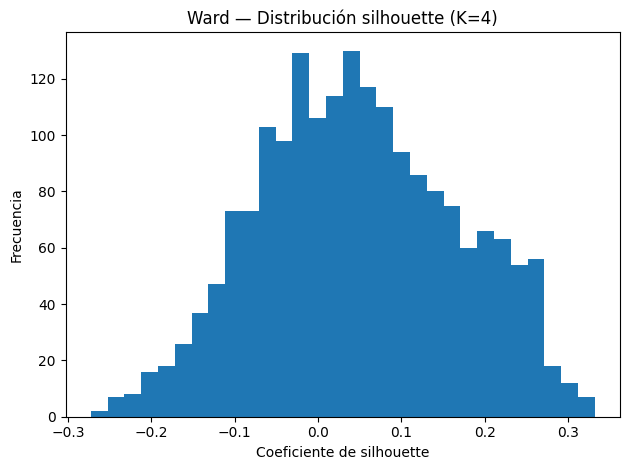

In [549]:

K_TO_PLOT = [2, 3, 4]  # ajusta según curvas anteriores

# K-Means
for k in K_TO_PLOT:
    km = KMeans(n_clusters=k, init="k-means++", n_init=50, random_state=7)
    labels = km.fit_predict(X_scaled)
    s = silhouette_samples(X_scaled, labels)
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(f"K-Means — Distribución silhouette (K={k})")
    plt.xlabel("Coeficiente de silhouette")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# Ward
for k in K_TO_PLOT:
    labels = fcluster(Z, t=k, criterion="maxclust")
    _, labels0 = np.unique(labels, return_inverse=True)
    s = silhouette_samples(X_scaled, labels0)
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(f"Ward — Distribución silhouette (K={k})")
    plt.xlabel("Coeficiente de silhouette")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


## Consenso entre índices y candidatos de K

- Qué hace: rankea K por cada índice y agrega (empate=promedio).
- Por qué: elegir 1–2 K candidatos por método con evidencia de varios criterios.

In [550]:
def rank_consensus(df_metrics, maximize_cols=("silhouette","calinski_harabasz"), minimize_cols=("davies_bouldin","inertia")):
    df = df_metrics.copy()
    # Ranks (1 = mejor)
    for c in maximize_cols:
        df[c + "_rank"] = (-df[c]).rank(method="average")  # mayor mejor
    for c in minimize_cols:
        df[c + "_rank"] = (df[c]).rank(method="average")   # menor mejor
    rank_cols = [c for c in df.columns if c.endswith("_rank")]
    df["consensus_rank"] = df[rank_cols].mean(axis=1)
    return df.sort_values("consensus_rank")

km_ranked   = rank_consensus(km_df)
ward_ranked = rank_consensus(ward_df)

print("\nK-Means — ranking de K (1 = mejor):")
display(km_ranked.round(3).head(3))

print("\nWard — ranking de K (1 = mejor):")
display(ward_ranked.round(3).head(3))

# Candidatos (toma los 1–2 mejores de cada método)
km_candidates   = list(km_ranked.index[:2])
ward_candidates = list(ward_ranked.index[:2])
print(f"Candidatos K (K-Means): {km_candidates}")
print(f"Candidatos K (Ward):   {ward_candidates}")



K-Means — ranking de K (1 = mejor):


,inertia,silhouette,calinski_harabasz,davies_bouldin,silhouette_rank,calinski_harabasz_rank,davies_bouldin_rank,inertia_rank,consensus_rank
K,,,,,,,,,
2,18730.290,0.166,391.042,2.100,1.0,1.0,5.0,9.0,4.00
9,13401.228,0.108,161.314,1.815,6.0,8.0,1.0,2.0,4.25
6,14950.107,0.110,192.798,2.045,4.0,5.0,4.0,5.0,4.50



Ward — ranking de K (1 = mejor):


,inertia,silhouette,calinski_harabasz,davies_bouldin,silhouette_rank,calinski_harabasz_rank,davies_bouldin_rank,inertia_rank,consensus_rank
K,,,,,,,,,
2,19456.449,0.136,306.169,2.368,1.0,1.0,4.0,9.0,3.75
7,15853.671,0.063,133.588,2.287,5.0,6.0,1.0,4.0,4.00
10,14566.545,0.065,115.182,2.291,4.0,9.0,2.0,1.0,4.00


Candidatos K (K-Means): [2, 9]
Candidatos K (Ward):   [2, 7]


## Guardar resultados (para el informe)

- Qué hace: persiste tablas con métricas por K y rankings.
- Por qué: trazabilidad en el reporte.

In [551]:
out_dir = Path("./k_selection_outputs"); out_dir.mkdir(exist_ok=True, parents=True)

km_df.to_csv(out_dir / "kmeans_k2_k10_metrics.csv")
ward_df.to_csv(out_dir / "ward_k2_k10_metrics.csv")
km_ranked.to_csv(out_dir / "kmeans_k2_k10_ranking.csv")
ward_ranked.to_csv(out_dir / "ward_k2_k10_ranking.csv")

print("Guardados en:", out_dir.resolve())


Guardados en: /app/k_selection_outputs


# Soluciones base para comparar (K=2 por defecto)

- Qué: entrena K-Means y Ward con K seleccionado (por defecto 2) para obtener labels_base.
- Por qué: las corridas de estabilidad comparan nuevas particiones contra esta referencia.

In [552]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering

K_SELECT = 2  # puedes cambiarlo si tu Paso 6 sugiere otro K

# --- Base K-Means ---
km_base = KMeans(n_clusters=K_SELECT, init="k-means++", n_init=50, random_state=7)
km_labels_base = km_base.fit_predict(X_scaled)

# --- Base Ward ---
agg_base = AgglomerativeClustering(n_clusters=K_SELECT, linkage="ward", metric="euclidean")
ward_labels_base = agg_base.fit_predict(X_scaled)

print("Listo: soluciones base entrenadas (K-Means y Ward).")


Listo: soluciones base entrenadas (K-Means y Ward).


## Utilidades: métricas externas y asignación por centroides

- Qué: funciones para ARI/NMI y para asignar etiquetas a todos los puntos desde centroides (útil en bootstrap).
- Por qué: en bootstrap entrenas con una muestra; luego etiquetas todo el conjunto comparando con la base.

In [553]:

def external_metrics(y_true, y_pred):
    return {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred)
    }

def nearest_centroid_assign(Xs, centroids):
    """Asigna cada fila de Xs al centroide más cercano (euclídea)."""
    # dist^2 = ||x||^2 + ||c||^2 - 2 x·c  (pero podemos usar L2 directo)
    # Aquí usamos L2 directa simple.
    dists = np.linalg.norm(Xs[:, None, :] - centroids[None, :, :], axis=2)  # (n, k)
    return np.argmin(dists, axis=1)


## Bootstrap de estabilidad (K-Means y Ward)

- Qué: muestrea con reemplazo, re-entrena en la muestra, obtiene centroides de clúster y etiqueta todo el dataset; luego ARI/NMI contra la base.
- Por qué: mide consistencia de la partición ante variaciones de los datos. Heurística: ARI medio > 0.7 ≈ buena estabilidad.

In [554]:
def bootstrap_stability_kmeans(Xs, base_labels, k, B=50, random_state=7):
    rng = np.random.default_rng(random_state)
    aris, nmis = [], []
    n = Xs.shape[0]
    for b in range(B):
        idx = rng.integers(0, n, size=n, endpoint=False)  # bootstrap con reemplazo
        km = KMeans(n_clusters=k, init="k-means++", n_init=50, random_state=rng.integers(1, 10_000))
        labels_inbag = km.fit_predict(Xs[idx])
        # Centroides del modelo ya están en km.cluster_centers_
        labels_all = nearest_centroid_assign(Xs, km.cluster_centers_)
        m = external_metrics(base_labels, labels_all)
        aris.append(m["ARI"]); nmis.append(m["NMI"])
    return np.array(aris), np.array(nmis)

def bootstrap_stability_ward(Xs, base_labels, k, B=50, random_state=7):
    rng = np.random.default_rng(random_state)
    aris, nmis = [], []
    n = Xs.shape[0]
    for b in range(B):
        idx = rng.integers(0, n, size=n, endpoint=False)
        agg = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
        labels_inbag = agg.fit_predict(Xs[idx])
        # Centroides por cluster (en la muestra)
        cents = []
        for c in range(k):
            mask = labels_inbag == c
            cents.append(Xs[idx][mask].mean(axis=0))
        cents = np.vstack(cents)
        labels_all = nearest_centroid_assign(Xs, cents)
        m = external_metrics(base_labels, labels_all)
        aris.append(m["ARI"]); nmis.append(m["NMI"])
    return np.array(aris), np.array(nmis)

# Ejecutar
km_boot_ari, km_boot_nmi = bootstrap_stability_kmeans(X_scaled, km_labels_base, K_SELECT, B=50, random_state=11)
wd_boot_ari, wd_boot_nmi = bootstrap_stability_ward(X_scaled, ward_labels_base, K_SELECT, B=50, random_state=11)

print("Bootstrap K-Means — ARI mean/std:", km_boot_ari.mean().round(3), km_boot_ari.std().round(3))
print("Bootstrap Ward   — ARI mean/std:", wd_boot_ari.mean().round(3), wd_boot_ari.std().round(3))


Bootstrap K-Means — ARI mean/std: 0.96 0.016
Bootstrap Ward   — ARI mean/std: 0.548 0.057


## Perturbación gaussiana (ruido pequeño sobre X_scaled)

- Qué: suma ruido ε·N(0,1) (ε pequeño) a las features, re-entrena y compara con la base (ARI/NMI).
- Por qué: mide robustez ante cambios sutiles de medición. Valores sugeridos: ε ∈ {0.02, 0.05, 0.1}.

In [555]:
def perturbation_stability_kmeans(Xs, base_labels, k, eps=0.05, R=30, random_state=7):
    rng = np.random.default_rng(random_state)
    aris, nmis = [], []
    for r in range(R):
        Xp = Xs + eps * rng.standard_normal(size=Xs.shape)
        km = KMeans(n_clusters=k, init="k-means++", n_init=50, random_state=rng.integers(1, 10_000))
        labels = km.fit_predict(Xp)
        m = external_metrics(base_labels, labels)
        aris.append(m["ARI"]); nmis.append(m["NMI"])
    return np.array(aris), np.array(nmis)

def perturbation_stability_ward(Xs, base_labels, k, eps=0.05, R=30, random_state=7):
    rng = np.random.default_rng(random_state)
    aris, nmis = [], []
    for r in range(R):
        Xp = Xs + eps * rng.standard_normal(size=Xs.shape)
        agg = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
        labels = agg.fit_predict(Xp)
        m = external_metrics(base_labels, labels)
        aris.append(m["ARI"]); nmis.append(m["NMI"])
    return np.array(aris), np.array(nmis)

# Ejecutar para varios epsilons
EPS_LIST = [0.02, 0.05, 0.10]
for eps in EPS_LIST:
    km_p_ari, km_p_nmi = perturbation_stability_kmeans(X_scaled, km_labels_base, K_SELECT, eps=eps, R=30, random_state=13)
    wd_p_ari, wd_p_nmi = perturbation_stability_ward(X_scaled, ward_labels_base, K_SELECT, eps=eps, R=30, random_state=13)
    print(f"[eps={eps}] K-Means ARI mean/std:", km_p_ari.mean().round(3), km_p_ari.std().round(3),
          " | Ward ARI mean/std:", wd_p_ari.mean().round(3), wd_p_ari.std().round(3))


[eps=0.02] K-Means ARI mean/std: 0.989 0.004  | Ward ARI mean/std: 0.633 0.107
[eps=0.05] K-Means ARI mean/std: 0.974 0.006  | Ward ARI mean/std: 0.585 0.122
[eps=0.1] K-Means ARI mean/std: 0.948 0.01  | Ward ARI mean/std: 0.582 0.087


## Gráficos simples de las distribuciones (histogramas)

- Qué: histogramas de ARI para bootstrap y perturbación.
- Por qué: visualizar dispersión; estabilidad buena → picos altos en ARI cercano a 1 y varianza baja.

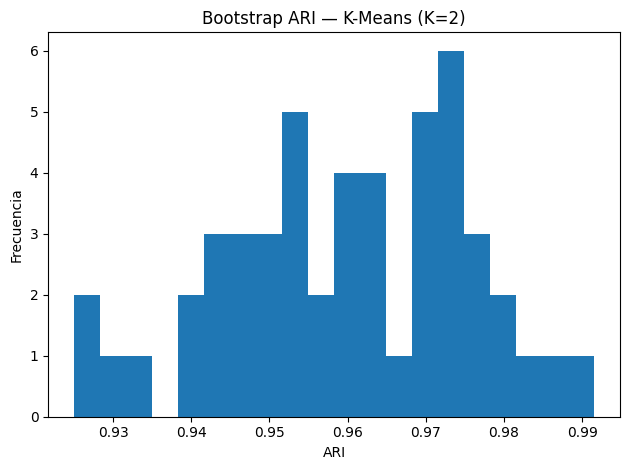

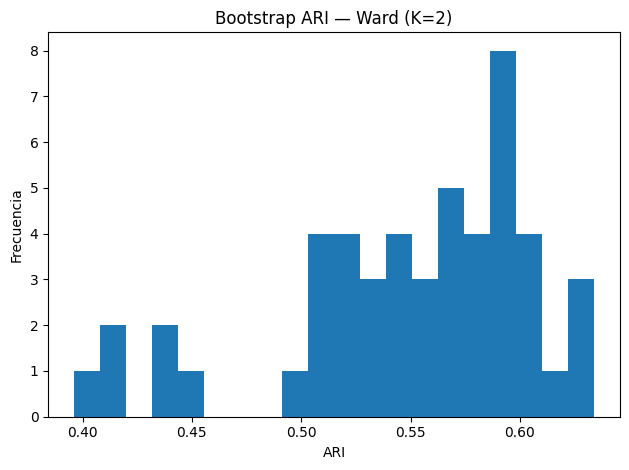

In [ ]:
def plot_hist(values, title):
    plt.figure()
    plt.hist(values, bins=20)
    plt.title(title)
    plt.xlabel("ARI")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# Bootstrap
plot_hist(km_boot_ari, "Bootstrap ARI — K-Means (K=2)")
plot_hist(wd_boot_ari, "Bootstrap ARI — Ward (K=2)")

# Perturbación (elige un eps)
eps = 0.05
km_p_ari, _ = perturbation_stability_kmeans(X_scaled, km_labels_base, K_SELECT, eps=eps, R=50, random_state=21)
wd_p_ari, _ = perturbation_stability_ward(X_scaled, ward_labels_base, K_SELECT, eps=eps, R=50, random_state=21)
plot_hist(km_p_ari, f"Perturbación ARI — K-Means (K=2, eps={eps})")
plot_hist(wd_p_ari, f"Perturbación ARI — Ward (K=2, eps={eps})")


## Resumen en tabla para el informe

- Qué: arma una tabla con medias y desvíos de ARI/NMI por método y protocolo.
- Por qué: reportar de forma clara y justificar el K “óptimo” por estabilidad.

In [ ]:
import numpy as np
import pandas as pd

def summarize(vals):
    vals = np.asarray(vals, dtype=float)
    return pd.Series({
        "mean": vals.mean(),
        "std":  vals.std(),
        "q25":  np.quantile(vals, 0.25),
        "q75":  np.quantile(vals, 0.75),
    })

def pack_row(method, protocol, metric, vals):
    stats = summarize(vals).to_dict()
    return {
        "method": method,
        "protocol": protocol,
        "metric": metric,
        **stats,  # merge de dicts
    }

rows = []

# Bootstrap
rows.append(pack_row("kmeans", "bootstrap", "ARI", km_boot_ari))
rows.append(pack_row("kmeans", "bootstrap", "NMI", km_boot_nmi))
rows.append(pack_row("ward",   "bootstrap", "ARI", wd_boot_ari))
rows.append(pack_row("ward",   "bootstrap", "NMI", wd_boot_nmi))

# Perturbación (ejemplo eps=0.05)
km_p_ari, km_p_nmi = perturbation_stability_kmeans(X_scaled, km_labels_base, K_SELECT, eps=0.05, R=50, random_state=31)
wd_p_ari, wd_p_nmi = perturbation_stability_ward(X_scaled, ward_labels_base, K_SELECT, eps=0.05, R=50, random_state=31)
rows.append(pack_row("kmeans", "perturb_eps0.05", "ARI", km_p_ari))
rows.append(pack_row("kmeans", "perturb_eps0.05", "NMI", km_p_nmi))
rows.append(pack_row("ward",   "perturb_eps0.05", "ARI", wd_p_ari))
rows.append(pack_row("ward",   "perturb_eps0.05", "NMI", wd_p_nmi))

summary_df = pd.DataFrame(rows, columns=["method","protocol","metric","mean","std","q25","q75"])
display(summary_df.round(3))


,method,protocol,metric,mean,std,q25,q75
0,kmeans,bootstrap,ARI,0.960,0.016,0.950,0.973
1,kmeans,bootstrap,NMI,0.923,0.025,0.905,0.941
2,ward,bootstrap,ARI,0.548,0.057,0.522,0.589
3,ward,bootstrap,NMI,0.463,0.049,0.432,0.500
4,kmeans,perturb_eps0.05,ARI,0.972,0.006,0.968,0.975
5,kmeans,perturb_eps0.05,NMI,0.940,0.011,0.933,0.945
6,ward,perturb_eps0.05,ARI,0.600,0.111,0.530,0.676
7,ward,perturb_eps0.05,NMI,0.514,0.096,0.451,0.583


## Parámetros finales y carpeta de artefactos

Qué / Por qué: define el K elegido (por tus pasos 6–7), semilla fija y preparamos carpeta para reproducibilidad.

In [ ]:
from pathlib import Path

BEST_K = 2          # <--- pon aquí el K elegido (según tus métricas + estabilidad)
RNG_SEED = 42       # semilla fija reproducible
N_INIT = 50         # muchos reinicios para K-Means

ART_DIR = Path("./final_artifacts")
ART_DIR.mkdir(exist_ok=True, parents=True)

# asegúrate de tener X y base_df
assert "age" in X.columns and "Nscore" in X.columns, "X debe ser socio+psicométricas"
try:
    has_id = "id" in base_df.columns
except NameError:
    has_id = False


## K-Means final: pipeline (Scaler + KMeans), labels y métricas

- Qué: ajusta un Pipeline con StandardScaler + KMeans usando random_state y n_init altos.
- Por qué: es la forma más reproducible y limpia de serializar todo el preprocesamiento y el modelo.

In [ ]:
import numpy as np
import pandas as pd

pipe_km = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=BEST_K, init="k-means++", n_init=N_INIT, random_state=RNG_SEED))
])

pipe_km.fit(X)                                  # entrena scaler + kmeans
labels_km = pipe_km.named_steps["kmeans"].labels_
X_scaled_final = pipe_km.named_steps["scaler"].transform(X)

# métricas internas finales (diagnóstico)
sil = silhouette_score(X_scaled_final, labels_km)
ch  = calinski_harabasz_score(X_scaled_final, labels_km)
db  = davies_bouldin_score(X_scaled_final, labels_km)

print({"silhouette": round(sil,3), "CH": round(ch,1), "DB": round(db,3)})

# dataframe de asignaciones
assign_km = (base_df[["id"]].copy() if has_id else pd.DataFrame({"row": np.arange(len(labels_km))}))
assign_km["cluster_kmeans"] = labels_km
assign_km.head()


{'silhouette': 0.166, 'CH': 391.0, 'DB': 2.1}


,id,cluster_kmeans
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


## Guardar Pipeline K-Means (modelo + scaler) y asignaciones

- Qué: serializa el pipeline completo con joblib, y guarda CSV con cluster_id por fila.
- Por qué: permite cargar y predecir en nuevos datos sin re-definir pasos.

In [ ]:
import joblib
import json
import sys, sklearn

# 1) Modelo completo (Scaler + KMeans)
joblib.dump(pipe_km, ART_DIR / "kmeans_pipeline.joblib")

# 2) Asignaciones por fila
assign_km.to_csv(ART_DIR / "labels_kmeans.csv", index=False)

# 3) Metadatos (parámetros, versiones, centroides en espacio estandarizado)
centroids_scaled = pipe_km.named_steps["kmeans"].cluster_centers_.tolist()
meta_km = {
    "best_k": BEST_K,
    "random_state": RNG_SEED,
    "n_init": N_INIT,
    "metrics": {"silhouette": float(sil), "calinski_harabasz": float(ch), "davies_bouldin": float(db)},
    "centroids_scaled": centroids_scaled,
    "versions": {
        "python": sys.version,
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scikit_learn": sklearn.__version__
    },
    "features": list(X.columns)
}
with open(ART_DIR / "kmeans_meta.json", "w") as f:
    json.dump(meta_km, f, indent=2)

print("Guardados K-Means en:", ART_DIR.resolve())


Guardados K-Means en: /app/final_artifacts


## Ward final: scaler + Ward + centroides y asignación

- Qué: ajusta StandardScaler y AgglomerativeClustering (ward). Ward no tiene .predict, así que guardamos centroides (promedios por cluster en espacio estandarizado) para asignar por vecino más cercano al recargar.
- Por qué: hace reproducible la etiquetación futura aun sin .predict() nativo.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# 1) Escalado final
scaler_w = StandardScaler().fit(X)
Xs_w = scaler_w.transform(X)

# 2) Ward final (K = BEST_K)
ward = AgglomerativeClustering(n_clusters=BEST_K, linkage="ward", metric="euclidean")
labels_ward = ward.fit_predict(Xs_w)

# 3) Centroides en espacio estandarizado (promedio por cluster)
centroids_w = []
for c in range(BEST_K):
    centroids_w.append(Xs_w[labels_ward == c].mean(axis=0))
centroids_w = np.vstack(centroids_w)

# 4) Asignaciones por fila
assign_wd = (base_df[["id"]].copy() if has_id else pd.DataFrame({"row": np.arange(len(labels_ward))}))
assign_wd["cluster_ward"] = labels_ward

# 5) Métricas internas (diagnóstico)
sil_w = silhouette_score(Xs_w, labels_ward)
ch_w  = calinski_harabasz_score(Xs_w, labels_ward)
db_w  = davies_bouldin_score(Xs_w, labels_ward)
print({"silhouette": round(sil_w,3), "CH": round(ch_w,1), "DB": round(db_w,3)})

# 6) Persistir: scaler, centroides, labels, metadatos
joblib.dump(scaler_w, ART_DIR / "ward_scaler.joblib")
np.save(ART_DIR / "ward_centroids_scaled.npy", centroids_w)
assign_wd.to_csv(ART_DIR / "labels_ward.csv", index=False)

meta_wd = {
    "best_k": BEST_K,
    "random_state": RNG_SEED,  # no aplica directo a Ward, pero lo dejamos por trazabilidad
    "metrics": {"silhouette": float(sil_w), "calinski_harabasz": float(ch_w), "davies_bouldin": float(db_w)},
    "versions": {
        "python": sys.version,
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scikit_learn": sklearn.__version__
    },
    "features": list(X.columns)
}
with open(ART_DIR / "ward_meta.json", "w") as f:
    json.dump(meta_wd, f, indent=2)

print("Guardados Ward en:", ART_DIR.resolve())


{'silhouette': 0.136, 'CH': 306.2, 'DB': 2.368}
Guardados Ward en: /app/final_artifacts


## Helpers para predecir en nuevos datos

- Qué: funciones de inferencia con ambos modelos, aplicables a nuevas filas con las mismas features.
- Por qué: documenta exactamente cómo reproducir/servir el clustering.

In [ ]:
import numpy as np
import pandas as pd
import joblib

def predict_kmeans_pipeline(df_new: pd.DataFrame, pipeline_path=ART_DIR/"kmeans_pipeline.joblib"):
    """
    df_new: DataFrame con exactamente las columnas de X (mismo orden y nombres).
    """
    pipe = joblib.load(pipeline_path)
    preds = pipe.predict(df_new)
    return preds

def predict_ward_nearest_centroid(df_new: pd.DataFrame,
                                  scaler_path=ART_DIR/"ward_scaler.joblib",
                                  centroids_path=ART_DIR/"ward_centroids_scaled.npy"):
    """
    Proyecta nuevas filas con el scaler guardado y asigna al centroide más cercano (euclídeo).
    """
    scaler = joblib.load(scaler_path)
    cents = np.load(centroids_path)
    Xs = scaler.transform(df_new.values)
    d = np.linalg.norm(Xs[:, None, :] - cents[None, :, :], axis=2)
    return np.argmin(d, axis=1)


## Snapshot de prevalencias por clúster (para tu informe)

- Qué: si ya tienes y_binario (19 drogas a 0/1), guarda prevalencias por clúster final de tu método elegido (e.g., K-Means).
- Por qué: lo pedirás en el análisis de grupos/patrones.

In [ ]:
# Supón que usarás K-Means final:
if "y_binario" in globals():
    df_out = (base_df[["id"]].copy() if has_id else pd.DataFrame({"row": np.arange(len(labels_km))}))
    df_out["cluster"] = labels_km
    prev_tables = {}
    for col in y_binario.columns:  # columnas *_bin + any_consumer
        prev = y_binario[col].groupby(df_out["cluster"]).mean().rename(col)  # promedio = % consumidores
        prev_tables[col] = prev
    prev_df = pd.DataFrame(prev_tables).T
    prev_df.to_csv(ART_DIR / "kmeans_prevalences_by_cluster.csv")
    print("Prevalencias por clúster guardadas.")


Prevalencias por clúster guardadas.


## Selección de partición final y matriz estandarizada

- Qué hace: elige los labels finales (K-Means o Ward) y garantiza X_scaled como DataFrame.
- Por qué: todo el perfilado se calculará en el espacio estandarizado.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Elige tu solución final
labels_final = labels_km  # <-- o usa labels_ward si elegiste Ward

# 2) Garantiza X_scaled (DataFrame) con nombres de columnas originales
try:
    Xs = X_scaled_final  # del paso 8 (pipeline K-Means)
except NameError:
    try:
        Xs = X_scaled     # si ya existe de pasos previos
    except NameError:
        scaler_tmp = StandardScaler().fit(X)
        Xs = scaler_tmp.transform(X)

X_scaled_df = pd.DataFrame(Xs, columns=X.columns, index=X.index)

k_final = len(np.unique(labels_final))
print("K final:", k_final, "| X_scaled shape:", X_scaled_df.shape)


K final: 2 | X_scaled shape: (1885, 12)


## Medias/medianas por clúster y z-scores (perfil)

- Qué hace: calcula medias y medianas de cada feature por clúster, y los z-scores de cada clúster.
- Por qué: los z-scores muestran sobre/infra-representación: positivo = por encima del promedio global, negativo = por debajo.

In [ ]:
# Medias y medianas (en escala original)
means_by_c = X.assign(cluster=labels_final).groupby("cluster").mean().T
meds_by_c  = X.assign(cluster=labels_final).groupby("cluster").median().T

# Z-scores de perfil: promedio de cada feature EN ESCALA ESTANDARIZADA
# (Equivale a: (mean_cluster - mean_global)/std_global)
Z = X_scaled_df.assign(cluster=labels_final).groupby("cluster").mean().T

print("Medias (primeras filas):")
display(means_by_c.head())
print("Z-scores (primeras filas):")
display(Z.head())


Medias (primeras filas):


cluster,0,1
age,-0.428259,0.426303
gender,-0.203259,0.171531
education,-0.354016,0.292552
country,-0.118066,0.756323
ethnicity,-0.286298,-0.329277


Z-scores (primeras filas):


cluster,0,1
age,-0.527110,0.446055
gender,-0.420766,0.356064
education,-0.368709,0.312013
country,-0.676439,0.572422
ethnicity,0.140082,-0.118542


## Top-5 features por |z| en cada clúster

- Qué hace: lista las 5 variables más distintivas (por magnitud de z) por clúster.
- Por qué: te da una lectura rápida de qué caracteriza a cada grupo.

In [ ]:
topk = 5
top_tables = {}
for c in Z.columns:  # cada cluster
    zc = Z[c].copy()
    top = zc.reindex(zc.abs().sort_values(ascending=False).index).head(topk)
    top_tables[c] = top

# Como tabla consolidada
top_df = pd.concat(top_tables, axis=1)
top_df.columns = [f"cluster_{c}" for c in Z.columns]
print(f"Top-{topk} por |z| en cada clúster:")
display(top_df)


Top-5 por |z| en cada clúster:


,cluster_0,cluster_1
country,-0.676439,0.572422
SS,0.640697,-0.542177
impulsive,0.559633,-0.473578
age,-0.527110,0.446055
Cscore,-0.489909,0.414575


## Heatmap de z-scores (clusters × features)

- Qué hace: mapa de calor simple de z-scores.
- Por qué: visualiza patrones globales (qué variables suben/bajan por clúster).
(Sin seaborn; matplotlib puro.)

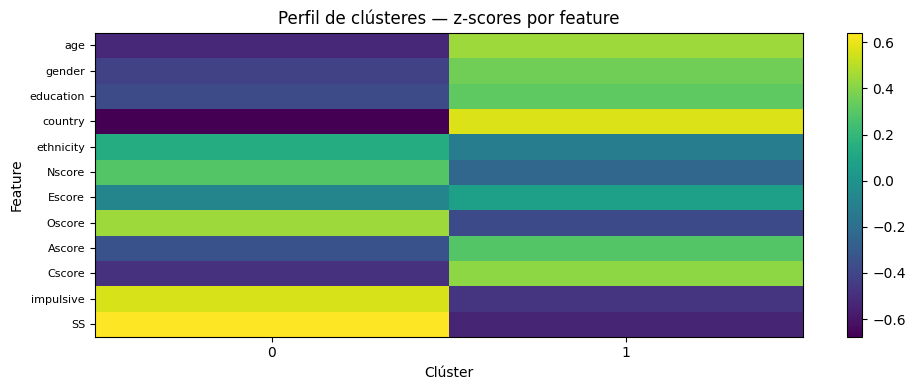

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, max(4, len(Z.index)*0.3)))
plt.imshow(Z.values, aspect="auto")
plt.title("Perfil de clústeres — z-scores por feature")
plt.xlabel("Clúster")
plt.ylabel("Feature")
plt.xticks(range(Z.shape[1]), Z.columns)
plt.yticks(range(Z.shape[0]), Z.index, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()


## PCA plot coloreado por clúster (solo ilustración)

- Qué hace: proyección PCA 2D para ilustrar la separación (no se usa para entrenar).
- Por qué: ayuda a explicar en el informe si los clústeres muestran alguna separación en las primeras PCs.

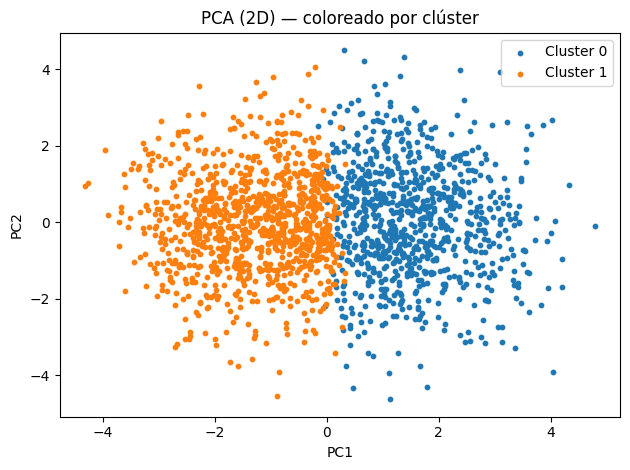

Varianza explicada: [24.25 15.6 ] %


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
scores = pca.fit_transform(X_scaled_df.values)

plt.figure()
for c in np.unique(labels_final):
    idx = (labels_final == c)
    plt.scatter(scores[idx, 0], scores[idx, 1], s=10, label=f"Cluster {c}")
plt.title("PCA (2D) — coloreado por clúster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

print("Varianza explicada:", np.round(pca.explained_variance_ratio_*100, 2), "%")


## Silhouette plot para tu K final

- Qué hace: grafica la distribución del coeficiente de silhouette de cada clúster.
- Por qué: complementa las métricas globales mostrando solapes o compactación por clúster.

Silhouette promedio: 0.166


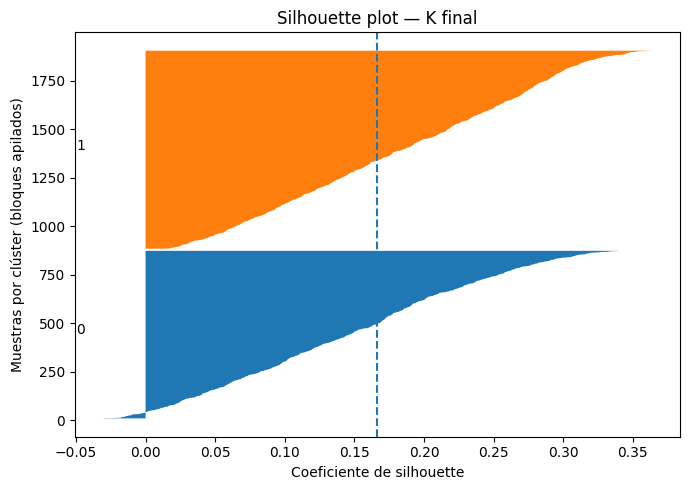

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

s_vals = silhouette_samples(X_scaled_df.values, labels_final)
sil_avg = silhouette_score(X_scaled_df.values, labels_final)
print("Silhouette promedio:", round(sil_avg, 3))

# Armado clásico del plot
plt.figure(figsize=(7, 5))
y_lower = 10
for c in np.unique(labels_final):
    sv = s_vals[labels_final == c]
    sv.sort()
    size_c = sv.shape[0]
    y_upper = y_lower + size_c
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, sv)
    plt.text(-0.05, y_lower + 0.5*size_c, str(c))
    y_lower = y_upper + 10

plt.axvline(sil_avg, linestyle="--")
plt.title("Silhouette plot — K final")
plt.xlabel("Coeficiente de silhouette")
plt.ylabel("Muestras por clúster (bloques apilados)")
plt.tight_layout()
plt.show()


## Guardar tablas para el informe

- Qué hace: exporta medias, medianas y z-scores.
- Por qué: podrás referenciarlas y construir gráficos/tablas fuera del notebook.

In [ ]:
from pathlib import Path
out_prof = Path("./profiling_outputs"); out_prof.mkdir(exist_ok=True, parents=True)

means_by_c.to_csv(out_prof / "means_by_cluster.csv")
meds_by_c.to_csv(out_prof  / "medians_by_cluster.csv")
Z.to_csv(out_prof          / "zscores_by_cluster.csv")
top_df.to_csv(out_prof     / "top_by_absz_per_cluster.csv")

print("Guardado en:", out_prof.resolve())


Guardado en: /app/profiling_outputs


## Esquema de binarización (elige uno y sé consistente)

- Qué hace: convierte CL0–CL6 a 0/1 según la política elegida:
    * ever: 1 si CL1–CL6 (alguna vez), 0 si CL0
    * recent: 1 si CL3–CL6 (≤1 año), 0 si CL0–CL2
    * frequent: 1 si CL4–CL6 (mensual+), 0 si CL0–CL3

In [ ]:
# 19 sustancias (incluye chocolate, caffeine, nicotine y la ficticia Semeron)
DRUG_COLS_ALL = [
    "alcohol","amphet","amyl","benzos","cannabis","choc","caff","coke",
    "crack","ecstasy","heroin","ketamine","legalh","lsd","meth","mushrooms",
    "nicotine","vsa","semer"
]

SCHEME = "ever"  # <-- elige: "ever" | "recent" | "frequent"

def cl_to_binary_scheme(cl_series: pd.Series, scheme: str = "ever") -> pd.Series:
    v = cl_series.astype(str).str.strip().str.upper()
    cl_num = v.str.replace("CL", "", regex=False).astype(int)
    if scheme == "ever":      # CL1..CL6 = 1
        return (cl_num >= 1).astype(int)
    elif scheme == "recent":  # CL3..CL6 = 1 (≤ 1 año)
        return (cl_num >= 3).astype(int)
    elif scheme == "frequent":# CL4..CL6 = 1 (mensual+)
        return (cl_num >= 4).astype(int)
    else:
        raise ValueError("scheme inválido. Usa: 'ever' | 'recent' | 'frequent'.")

# Construye matriz binaria Y (19 columnas *_bin)
Y = pd.DataFrame(index=base_df.index)
for drug in DRUG_COLS_ALL:
    Y[drug + "_bin"] = cl_to_binary_scheme(base_df[drug], SCHEME).astype(int)

# Serie de clúster
clusters = pd.Series(labels_final, index=base_df.index, name="cluster")
k_final = clusters.nunique()
print(f"Esquema: {SCHEME} | K={k_final} | Y shape: {Y.shape}")
Y.head()


Esquema: ever | K=2 | Y shape: (1885, 19)


,alcohol_bin,amphet_bin,amyl_bin,benzos_bin,cannabis_bin,choc_bin,caff_bin,coke_bin,crack_bin,ecstasy_bin,heroin_bin,ketamine_bin,legalh_bin,lsd_bin,meth_bin,mushrooms_bin,nicotine_bin,vsa_bin,semer_bin
0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
4,1,1,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0


## Prevalencia (%) por clúster

- Qué hace: para cada sustancia, calcula el % de 1s por clúster.
- Por qué: es tu tabla base para el informe y para los gráficos

In [ ]:
# Prevalencias por clúster (%), una fila por sustancia
prev_by_cluster = {}
for drug in DRUG_COLS_ALL:
    g = Y[drug + "_bin"].groupby(clusters).mean() * 100.0
    prev_by_cluster[drug] = g

prev_df = pd.DataFrame(prev_by_cluster).T  # columnas = clusters
prev_df.columns = [f"cluster_{c}" for c in prev_df.columns]  # nombres amigables
prev_df["range_pp"] = prev_df.max(axis=1) - prev_df.min(axis=1)  # rango (%-point) entre clústeres

print("Prevalencia (%) por clúster (primeras filas):")
prev_df.round(2).head()


Prevalencia (%) por clúster (primeras filas):


,cluster_0,cluster_1,range_pp
alcohol,98.38,98.04,0.34
amphet,65.39,33.69,31.70
amyl,32.75,29.09,3.67
benzos,63.54,32.91,30.63
cannabis,95.60,63.27,32.33


## χ² de independencia, V de Cramér y BH-FDR

- Qué hace: prueba asociación clúster×consumo para cada droga; calcula tamaño de efecto (Cramér’s V).
- Por qué: medir significancia y magnitud de la asociación. BH controla falsos descubrimientos por múltiples pruebas.

In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(chi2, n, r, c):
    k = min(r, c)
    if k <= 1: 
        return np.nan
    return np.sqrt(chi2 / (n * (k - 1)))

def benjamini_hochberg(pvals):
    """Devuelve p-vals ajustados (q-values) por BH-FDR."""
    p = np.asarray(pvals, dtype=float)
    m = p.size
    order = np.argsort(p)
    q = np.empty(m, dtype=float)
    cummin = 1.0
    for i in range(m - 1, -1, -1):
        rank = i + 1
        val = p[order[i]] * m / rank
        cummin = min(cummin, val)
        q[order[i]] = cummin
    return np.clip(q, 0, 1)

rows = []
for drug in DRUG_COLS_ALL:
    ct = pd.crosstab(clusters, Y[drug + "_bin"])  # shape K x 2
    chi2, p, dof, exp = chi2_contingency(ct)
    n = int(ct.values.sum())
    V = cramers_v(chi2, n, *ct.shape)
    rows.append({"drug": drug, "chi2": chi2, "p": p, "dof": dof, "cramers_v": V})

chi_df = pd.DataFrame(rows).set_index("drug")
chi_df["p_adj_bh"] = benjamini_hochberg(chi_df["p"].values)

def interpret_v(v):
    if np.isnan(v): return "NA"
    if v < 0.10:   return "trivial"
    if v < 0.30:   return "pequeño"
    if v < 0.50:   return "mediano"
    return "grande"

chi_df["effect"] = chi_df["cramers_v"].apply(interpret_v)
chi_df["signif_0.05"] = chi_df["p_adj_bh"] < 0.05

# Tabla resumen ordenada por significancia y efecto
summary = prev_df.join(chi_df).sort_values(["p_adj_bh","cramers_v"])
summary.round(3).head(10)


,cluster_0,cluster_1,range_pp,chi2,p,dof,cramers_v,p_adj_bh,effect,signif_0.05
legalh,69.444,18.707,50.737,492.584,0.0,1,0.511,0.0,grande,True
mushrooms,70.602,28.697,41.904,327.609,0.0,1,0.417,0.0,mediano,True
ecstasy,68.171,26.934,41.237,318.882,0.0,1,0.411,0.0,mediano,True
lsd,65.509,24.486,41.023,319.141,0.0,1,0.411,0.0,mediano,True
cannabis,95.602,63.271,32.331,284.017,0.0,1,0.388,0.0,mediano,True
meth,40.856,10.088,30.768,239.906,0.0,1,0.357,0.0,mediano,True
amphet,65.394,33.692,31.701,187.091,0.0,1,0.315,0.0,mediano,True
coke,61.690,30.754,30.936,179.756,0.0,1,0.309,0.0,mediano,True
benzos,63.542,32.909,30.633,175.083,0.0,1,0.305,0.0,mediano,True
vsa,35.532,12.047,23.485,145.263,0.0,1,0.278,0.0,pequeño,True


## Heatmap de prevalencias (clusters × sustancias)

- Qué hace: visualiza las tasas (%) por clúster; ordena filas por p-ajustada (más asociadas arriba).
- Por qué: foto rápida de diferencias entre clústeres.

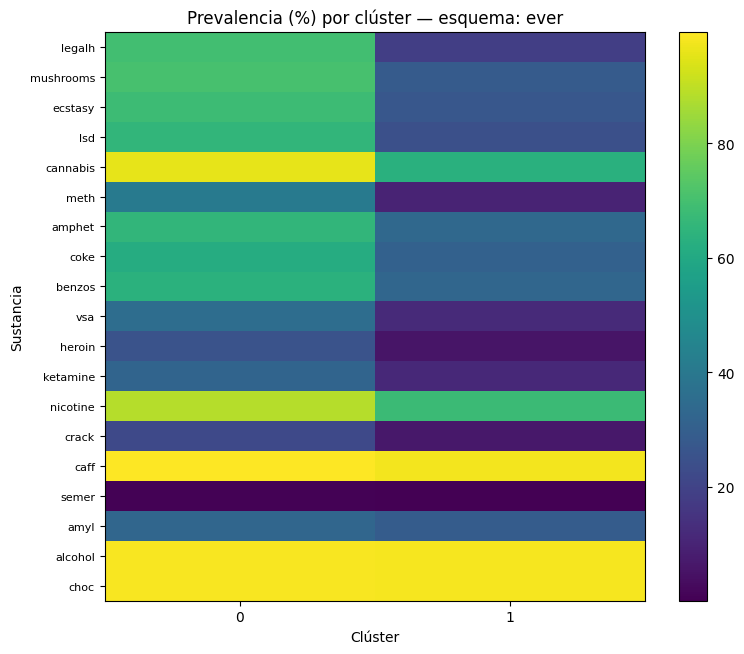

In [ ]:
import matplotlib.pyplot as plt

# Orden de drogas por significancia
order = summary.index.tolist()

M = prev_df.loc[order, [c for c in prev_df.columns if c.startswith("cluster_")]].values
plt.figure(figsize=(8, max(4, len(order)*0.35)))
plt.imshow(M, aspect="auto")
plt.title(f"Prevalencia (%) por clúster — esquema: {SCHEME}")
plt.xlabel("Clúster")
plt.ylabel("Sustancia")
plt.xticks(ticks=range(len(prev_df.columns)-1), labels=[c.split("_")[1] for c in prev_df.columns if c.startswith("cluster_")])
plt.yticks(ticks=range(len(order)), labels=order, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()


## Barras apiladas por sustancia (top-N más asociadas)

- Qué hace: para cada droga (top-N por p-ajustada), muestra barras apiladas %No/%Sí por clúster.
- Por qué: comunica fácil la magnitud de diferencias

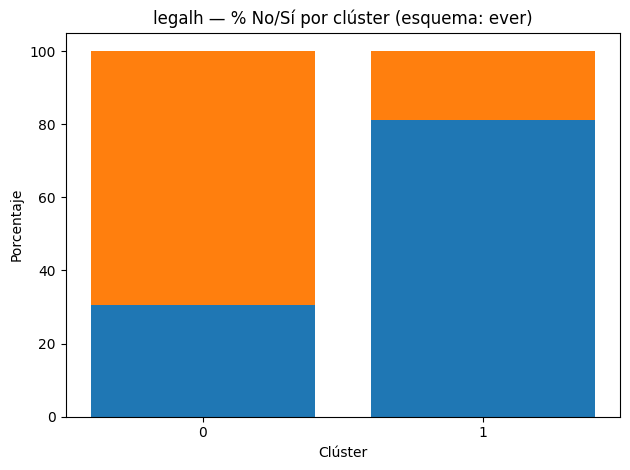

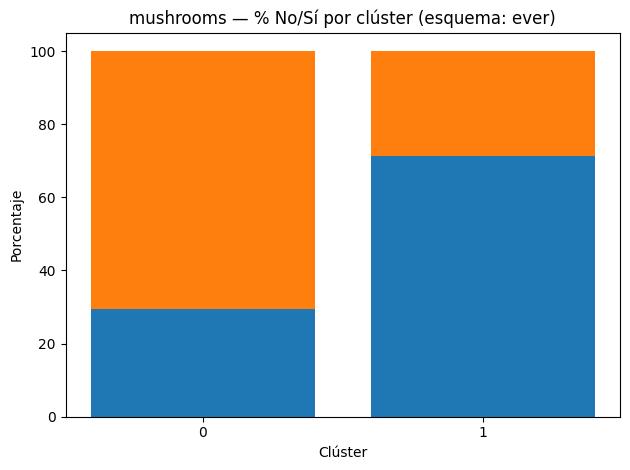

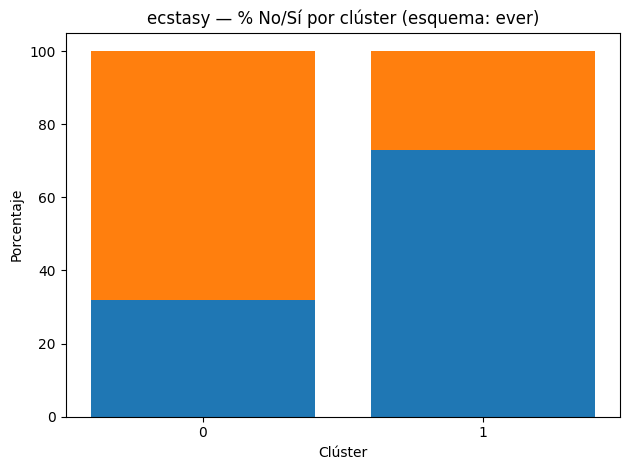

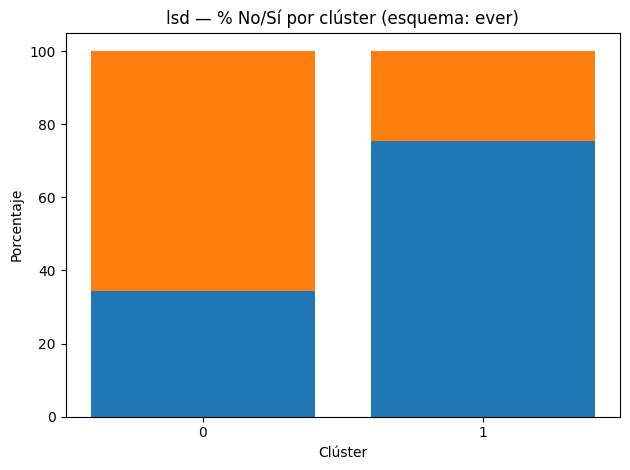

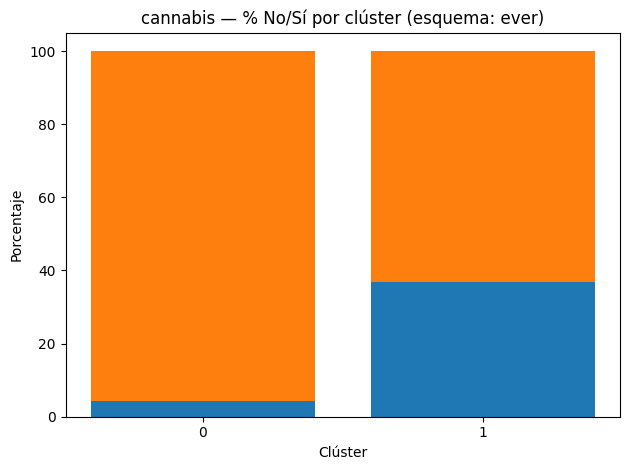

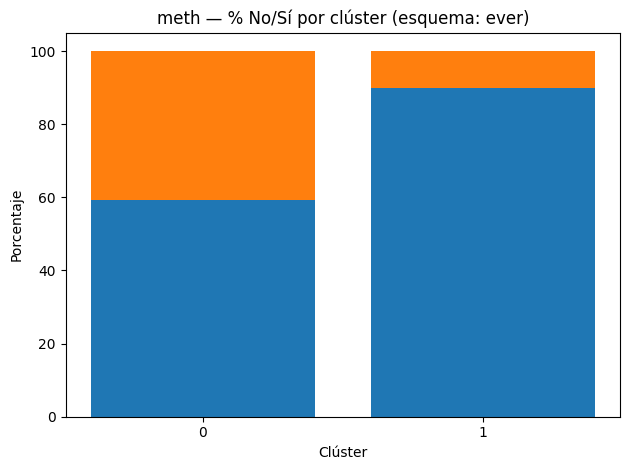

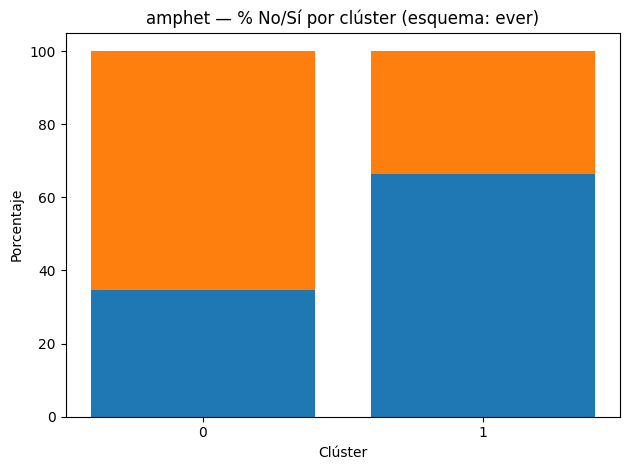

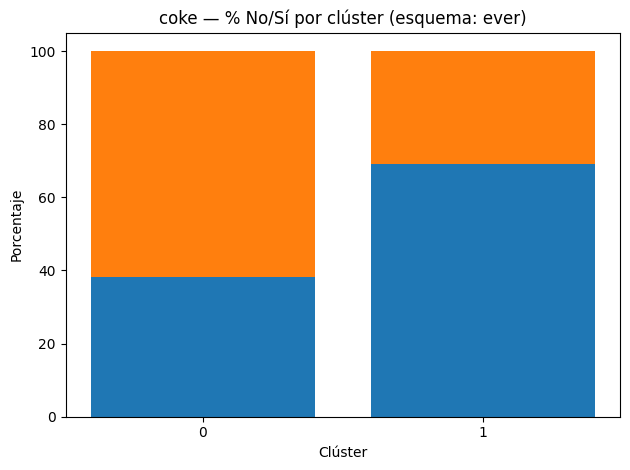

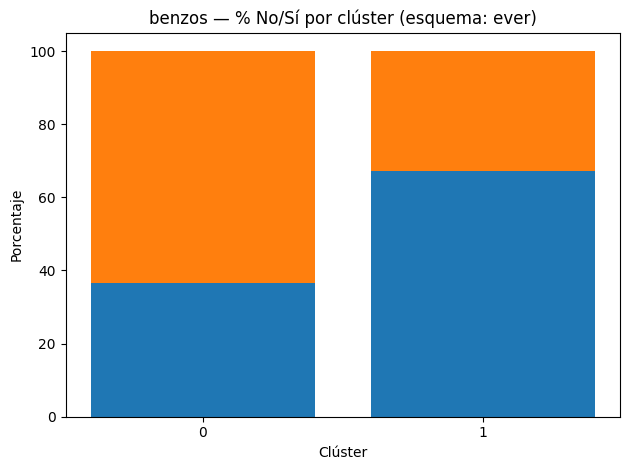

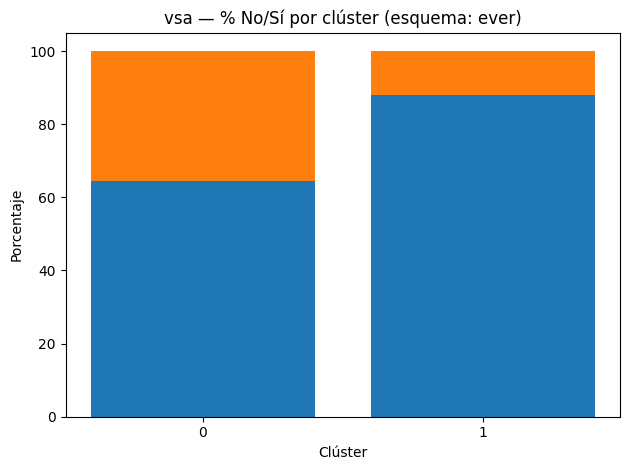

In [ ]:
# Top-N sustancias por evidencia (p-ajustada más baja)
TOP_N = 10
top_subs = summary.head(TOP_N).index.tolist()

cluster_cols = [c for c in prev_df.columns if c.startswith("cluster_")]
cluster_ids  = [int(c.split("_")[1]) for c in cluster_cols]  # e.g., [0,1]

def plot_stacked_for_drug(drug):
    p1 = prev_df.loc[drug, cluster_cols].values
    p0 = 100.0 - p1
    x = np.arange(len(cluster_cols))
    plt.figure()
    plt.bar(x, p0)             # No consumidores
    plt.bar(x, p1, bottom=p0)  # Sí consumidores
    plt.title(f"{drug} — % No/Sí por clúster (esquema: {SCHEME})")
    plt.xlabel("Clúster")
    plt.ylabel("Porcentaje")
    plt.xticks(x, cluster_ids)
    plt.tight_layout()
    plt.show()

for drug in top_subs:
    plot_stacked_for_drug(drug)


## Guardar tablas para el informe

- Qué hace: exporta prevalencias, resultados de χ²/V y la tabla resumen ordenada.
- Por qué: trazabilidad y uso en figuras externas.

In [ ]:
from pathlib import Path
out_rel = Path("./cluster_drug_relation_outputs"); out_rel.mkdir(exist_ok=True, parents=True)

prev_df.to_csv(out_rel / f"prevalence_by_cluster_{SCHEME}.csv")
chi_df.to_csv(out_rel  / f"chi2_cramers_{SCHEME}.csv")
summary.to_csv(out_rel  / f"summary_{SCHEME}.csv")

print("Guardado en:", out_rel.resolve())


Guardado en: /app/cluster_drug_relation_outputs


## Setup común (elige método/K final y K alternativo)

- Qué hace: fija tu solución final (método + K), prepara X_scaled y define tu K alternativo.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Elige tu solución final ===
METHOD   = "kmeans"   # "kmeans" o "ward"
K_FINAL  = 2          # tu K elegido (de pasos 6–8)
K_ALT    = 3          # tu 2.º mejor K (modifícalo según tu ranking)

# Etiquetas finales (ajusta según tu elección)
if METHOD == "kmeans":
    labels_final = labels_km
else:
    labels_final = labels_ward

# Asegura X_scaled disponible (DataFrame)
try:
    Xs = X_scaled_final  # del pipeline K-Means (paso 8)
except NameError:
    try:
        Xs = X_scaled    # si ya existe
    except NameError:
        scaler_tmp = StandardScaler().fit(X)
        Xs = scaler_tmp.transform(X)

X_scaled_df = pd.DataFrame(Xs, columns=X.columns, index=X.index)

# Lista de drogas (19)
DRUG_COLS_ALL = [
    "alcohol","amphet","amyl","benzos","cannabis","choc","caff","coke",
    "crack","ecstasy","heroin","ketamine","legalh","lsd","meth","mushrooms",
    "nicotine","vsa","semer"
]


## Helpers: binarizar CL, χ² + Cramér, BH-FDR, prevalencias y resumen

- Qué hace: funciones para construir Y binario, calcular tablas de prevalencia, χ², V de Cramér y p-ajustada (BH), y empaquetar resultados comparables.

In [ ]:
from scipy.stats import chi2_contingency

def cl_to_binary_scheme(cl_series: pd.Series, scheme: str = "ever") -> pd.Series:
    v = cl_series.astype(str).str.strip().str.upper()
    cl_num = v.str.replace("CL", "", regex=False).astype(int)
    if scheme == "ever":       # CL1..CL6 = 1
        return (cl_num >= 1).astype(int)
    elif scheme == "recent":   # CL3..CL6 = 1 (≤ 1 año)
        return (cl_num >= 3).astype(int)
    elif scheme == "frequent": # CL4..CL6 = 1 (mensual+)
        return (cl_num >= 4).astype(int)
    else:
        raise ValueError("scheme inválido: usa 'ever'|'recent'|'frequent'.")

def benjamini_hochberg(pvals):
    p = np.asarray(pvals, dtype=float); m = p.size
    order = np.argsort(p); q = np.empty(m); cummin = 1.0
    for i in range(m-1, -1, -1):
        rank = i+1; val = p[order[i]] * m / rank
        cummin = min(cummin, val); q[order[i]] = cummin
    return np.clip(q, 0, 1)

def cramers_v(chi2, n, r, c):
    k = min(r, c)
    return np.sqrt(chi2 / (n * (k - 1))) if k > 1 else np.nan

def build_binary_Y(base_df: pd.DataFrame, scheme: str) -> pd.DataFrame:
    Y = pd.DataFrame(index=base_df.index)
    for drug in DRUG_COLS_ALL:
        Y[drug + "_bin"] = cl_to_binary_scheme(base_df[drug], scheme).astype(int)
    return Y

def prevalence_by_cluster(Ybin: pd.DataFrame, clusters: pd.Series) -> pd.DataFrame:
    out = {}
    for drug in DRUG_COLS_ALL:
        out[drug] = Ybin[drug + "_bin"].groupby(clusters).mean() * 100.0
    prev = pd.DataFrame(out).T
    prev.columns = [f"cluster_{c}" for c in prev.columns]
    prev["range_pp"] = prev.max(axis=1) - prev.min(axis=1)
    return prev

def chi2_and_effects(Ybin: pd.DataFrame, clusters: pd.Series) -> pd.DataFrame:
    rows = []
    for drug in DRUG_COLS_ALL:
        ct = pd.crosstab(clusters, Ybin[drug + "_bin"])       # K x 2
        chi2, p, dof, exp = chi2_contingency(ct)
        n = int(ct.values.sum())
        rows.append({"drug": drug, "chi2": chi2, "p": p, "dof": dof,
                     "cramers_v": cramers_v(chi2, n, *ct.shape)})
    chi_df = pd.DataFrame(rows).set_index("drug")
    chi_df["p_adj_bh"] = benjamini_hochberg(chi_df["p"].values)
    return chi_df

def summarize_relation(base_df, clusters, scheme="ever"):
    Y = build_binary_Y(base_df, scheme)
    prev = prevalence_by_cluster(Y, clusters)
    chi  = chi2_and_effects(Y, clusters)
    summary = prev.join(chi).sort_values(["p_adj_bh","cramers_v"])
    return {"Y": Y, "prev": prev, "chi": chi, "summary": summary}


## Sensibilidad por esquema (ever vs recent vs frequent)

- Qué hace: corre el bloque de relación clúster↔consumo para cada esquema, y compara consistencia de conclusiones:
    - Jaccard de top-N sustancias (por p-ajustada o por efecto).
    - Correlación de V de Cramér por sustancia entre esquemas.

In [ ]:
from scipy.stats import spearmanr

SCHEMES = ["ever","recent","frequent"]
results_by_scheme = {}
clusters = pd.Series(labels_final, index=base_df.index, name="cluster")

for sch in SCHEMES:
    results_by_scheme[sch] = summarize_relation(base_df, clusters, scheme=sch)

# Comparación de conclusiones (top-N por p-ajustada y por efecto)
TOP_N = 10
comparisons = []
for i in range(len(SCHEMES)):
    for j in range(i+1, len(SCHEMES)):
        a, b = SCHEMES[i], SCHEMES[j]
        Sa = results_by_scheme[a]["summary"]; Sb = results_by_scheme[b]["summary"]

        top_a_p = set(Sa.index[:TOP_N])
        top_b_p = set(Sb.index[:TOP_N])
        jacc_p  = len(top_a_p & top_b_p) / len(top_a_p | top_b_p)

        # por efecto (V)
        top_a_v = set(Sa.sort_values("cramers_v", ascending=False).index[:TOP_N])
        top_b_v = set(Sb.sort_values("cramers_v", ascending=False).index[:TOP_N])
        jacc_v  = len(top_a_v & top_b_v) / len(top_a_v | top_b_v)

        # correlación de V por droga (Spearman)
        Va = results_by_scheme[a]["chi"]["cramers_v"].reindex(DRUG_COLS_ALL)
        Vb = results_by_scheme[b]["chi"]["cramers_v"].reindex(DRUG_COLS_ALL)
        rho, pval = spearmanr(Va, Vb, nan_policy="omit")

        comparisons.append({
            "pair": f"{a} vs {b}",
            "jaccard_topN_p": jacc_p,
            "jaccard_topN_V": jacc_v,
            "spearman_V_rho": rho,
            "spearman_V_p": pval
        })

comp_df = pd.DataFrame(comparisons)
print("Consistencia entre esquemas de binarización:")
display(comp_df.round(3))


Consistencia entre esquemas de binarización:


,pair,jaccard_topN_p,jaccard_topN_V,spearman_V_rho,spearman_V_p
0,ever vs recent,0.818,0.818,0.912,0.0
1,ever vs frequent,0.818,0.818,0.782,0.0
2,recent vs frequent,1.000,1.000,0.942,0.0


## K alternativo: reentrenar y comparar con el final

- Qué hace: vuelve a entrenar con K_ALT usando tu método elegido; alinea clústeres por centroides (húngaro) y compara:
    - ARI/NMI de etiquetas (si K coincide; si no, alinea y reporta NMI/ARI igualmente).
    - Consistencia de conclusiones en consumo (Jaccard top-N y correlación de V).

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def cluster_centroids(Xs, labels):
    labels = np.asarray(labels)
    cents = []
    ids = np.unique(labels)
    for c in ids:
        cents.append(Xs[labels == c].mean(axis=0))
    return np.vstack(cents), ids

def align_alt_to_base(Xs, labels_base, labels_alt):
    """
    Alinea etiquetas 'labels_alt' al espacio de 'labels_base':
    - Empareja centroides con Hungarian.
    - Cubre TODOS los clústeres alternativos (si k_alt>k_base, los sobrantes van al centroide base más cercano).
    Devuelve: (labels_alt_aligned, mapping_dict)
    """
    Cb, base_ids = cluster_centroids(Xs, labels_base)  # shape (k_base, d)
    Ca, alt_ids  = cluster_centroids(Xs, labels_alt)   # shape (k_alt, d)

    # Distancias alt->base
    D = np.linalg.norm(Ca[:, None, :] - Cb[None, :, :], axis=2)  # (k_alt, k_base)

    # Empareja tantos como se pueda (min(k_alt,k_base))
    r, c = linear_sum_assignment(D)

    mapping = {}
    # 1) Pairs del húngaro
    for i in range(len(r)):
        mapping[int(alt_ids[r[i]])] = int(base_ids[c[i]])

    # 2) Alt restantes (si k_alt > k_base): asigna al centroide base más cercano
    unmatched_alt = set(map(int, alt_ids)) - set(mapping.keys())
    if unmatched_alt:
        for ai, alt_id in enumerate(alt_ids):
            aid = int(alt_id)
            if aid in unmatched_alt:
                nearest_base = int(base_ids[np.argmin(D[ai])])
                mapping[aid] = nearest_base

    # Aplica mapping a TODAS las etiquetas alt
    labels_alt = np.asarray(labels_alt)
    labels_alt_aligned = np.vectorize(lambda z: mapping[int(z)])(labels_alt)

    return labels_alt_aligned, mapping


## Clústeres pequeños: revisar si son ruido o segmento real

- Qué hace: calcula proporciones de clúster para la solución final y la alternativa; marca clústeres con p<τ (3–5%).

In [ ]:
def cluster_sizes(labels):
    vc = pd.Series(labels).value_counts(normalize=True).sort_index()
    return (vc*100).rename("pct")

TAU = 0.05  # 5% (ajusta a 0.03 si quieres umbral 3%)

sizes_final = cluster_sizes(labels_final)
sizes_alt   = cluster_sizes(labels_alt)

print("Tamaño de clústeres (final, %):")
display(sizes_final.round(2))
print("Clústeres pequeños (final):", list(sizes_final[sizes_final < TAU*100].index))

print("Tamaño de clústeres (K alternativo, %):")
display(sizes_alt.round(2))
print("Clústeres pequeños (alt):", list(sizes_alt[sizes_alt < TAU*100].index))


Tamaño de clústeres (final, %):


0    45.84
1    54.16
Name: pct, dtype: float64

Clústeres pequeños (final): []
Tamaño de clústeres (K alternativo, %):


0    28.59
1    26.84
2    44.56
Name: pct, dtype: float64

Clústeres pequeños (alt): []
